In [1]:
!nvidia-smi

Sat May 22 05:33:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install opendatasets --upgrade --quiet

In [ ]:
!pip3 install gdown

In [ ]:
!gdown --id 129ruKo5e03Uwx7El5iZfXvbJVsojrav9
!gdown --id 12L9rI_Iaz36ztXeBM5662IraTICOWHsV
!gdown --id 1H-dhrytDv4MqUKTeE4ZCooHB2CwyMmZs
!gdown --id 1TqaRC5FY0agW4ItuG34yq4kGFKhf6gqb
!gdown --id 1Z1sG0dUuzutCBYoRP8bD3FXplK3RbSoV
!gdown --id 1-3pW4BzMfaDRwvoqal6IMD6E95cDlwsS
!gdown --id 1gKnaDTTRkeYabX5Ee3c7ngNutw_fpeu8
!gdown --id 16J8a0Bl25u66RKKJKe9Ck1TytoQU5c3r
# Inception
!gdown --id 1497cH6V43YwTK-DGpMwHg99USy0Je7FX
#Model Weights 
!gdown --id 1h3k4oaxH_OvTychCALVjOGpnFFzOCxgV
!gdown --id 1NOPFRCEdupHOziUDnUn_4KnvEnpOhPT5               

!mkdir state_dicts
!mv ./inception_v3.pt ./state_dicts/
!mv ./vgg13_bn.pt ./state_dicts/
!mv ./resnet18.pt ./state_dicts/

In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/swaroopkml/cifar10-pngs-in-folders")
use_cuda=True

In [ ]:
!pip install pytorch-lightning

In [7]:
from __future__ import print_function
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pytorch_lightning
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import save_image
from torchvision.datasets import ImageFolder
import os
from tqdm.notebook import tqdm
from torchvision.utils import make_grid
from torchvision import models
from torch import Tensor
from torch.autograd import Variable
from torch.nn.utils import spectral_norm
import pickle


In [8]:
batch_size_69=96*8
epsilon_range = 1 + (batch_size_69 / 6)
generate_noise = True
input_shape = (3, 32, 32)          # image size

train_loader = torch.utils.data.DataLoader(
                ImageFolder('./cifar10-pngs-in-folders/cifar10/cifar10/train',  
                        transform=transforms.Compose([ transforms.ToTensor() ])),
                        batch_size=batch_size_69, 
                        shuffle=True,
                        num_workers=4,
                        pin_memory=True)

test_loader = torch.utils.data.DataLoader(
                ImageFolder('./cifar10-pngs-in-folders/cifar10/cifar10/test', 
                        transform=transforms.Compose([ transforms.ToTensor()])),
                        batch_size=batch_size_69,
                        num_workers=4,
                        pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


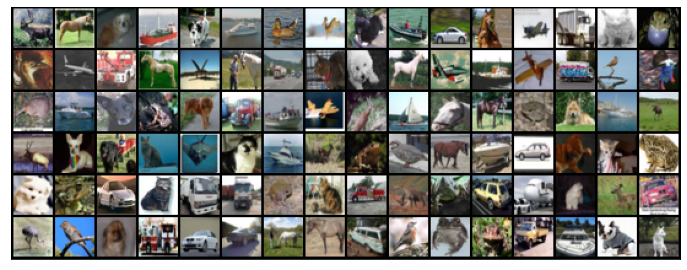

In [9]:
# def denorm(image_tensor):
#     return image_tensor*mean[0] + std[0]
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

show_batch(train_loader)

In [10]:

gpu_devices = ','.join([str(id) for id in [0,1,2,3,4,5,6,7]])
os.environ["CUDA_VISIBLE_DEVICES"] = gpu_devices

In [11]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True) 


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [12]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, "last_lr: {:.5f},".format(result['lrs'][-1]) if 'lrs' in result else '', 
            result['train_loss'], result['val_loss'], result['val_acc']))


In [13]:
from vgg import vgg13_bn
from resnet import resnet18
from inception import inception_v3


class vgg13(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = vgg13_bn(pretrained=True)
        self.feature = nn.Sequential(*list(self.network.features.children())[:18] )
        #self.network.eval()
        
    def forward(self,images):
        return self.network(images)

    def feature_extractor(self,x):
        """Extract multiple convolutional feature maps."""
        return self.feature(x)



class resnet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = resnet18(pretrained=True)
        #self.network.eval()
        
    def forward(self,images):
        return self.network(images)

class inception(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = inception_v3(pretrained=True) 
        
        
    def forward(self,images):
        return self.network(images)

    def feature_extractor(self,x):
        """Extract multiple convolutional feature maps."""
        for i,(name, layer) in enumerate(self.network._modules.items()):
          x = layer(x)
          if i == 11:                                      # 8 = torch.Size([64, 1280, 15, 15])
            return x
          


In [14]:
device = get_default_device()
pre_discriminator_2 = to_device( inception(), device)
classifier = to_device(  vgg13(), device)
resnet_model = to_device( resnet(), device)
train_loader = DeviceDataLoader(train_loader, device)
test_loader =  DeviceDataLoader(test_loader, device)

pre_discriminator_2.load_state_dict(torch.load("inception_trained.pth"))

<All keys matched successfully>

In [15]:
# for image , l in train_loader:
#   print(classifier.feature_extractor(image).shape)
#   print(discriminator_2.feature_extractor(image).shape)
#   break;

In [16]:
@torch.no_grad()
def evaluate(model , val_loader, val=True):
    if val:
        model.eval()
    outputs = [model.validation_step(batch) for batch in tqdm(val_loader)]
    return model.validation_epoch_end(outputs)

print("discriminator_2 Train Accuracy: ",evaluate(pre_discriminator_2 , train_loader, val=False) )
print("discriminator_2 Test  Accuracy: ",evaluate(pre_discriminator_2 , test_loader))

print("classifier Train Accuracy : ",evaluate(classifier, train_loader, val=False))
print("classifier Test  Accuracy : ",evaluate(classifier, test_loader) )

print("resnet Train Accuracy : ",evaluate(resnet_model, train_loader, val=False))
print("resnet Test  Accuracy : ",evaluate(resnet_model, test_loader) )

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



discriminator_2 Train Accuracy:  {'val_loss': 0.02818136475980282, 'val_acc': 0.9929822683334351}



discriminator_2 Test  Accuracy:  {'val_loss': 0.2454504370689392, 'val_acc': 0.9316467046737671}



classifier Train Accuracy :  {'val_loss': 0.04334130138158798, 'val_acc': 0.9936980605125427}



classifier Test  Accuracy :  {'val_loss': 0.2323404848575592, 'val_acc': 0.9314483404159546}



resnet Train Accuracy :  {'val_loss': 0.05624784901738167, 'val_acc': 0.9900990724563599}



resnet Test  Accuracy :  {'val_loss': 0.2754327356815338, 'val_acc': 0.9217261672019958}


In [17]:
# scaler = torch.cuda.amp.GradScaler()

# # Train Inception Further
# def get_lr(optimizer):
#     for param_group in optimizer.param_groups:
#         return param_group['lr']

# def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
#                   weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
#     torch.cuda.empty_cache()
#     history = []
    
#     # Set up cutom optimizer with weight decay
#     optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
#     # Set up one-cycle learning rate scheduler
#     sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
#                                                 steps_per_epoch=len(train_loader))
    
#     for epoch in range(epochs):
#         # Training Phase 
#         model.train()
#         train_losses = []
#         lrs = []
#         for batch in tqdm(train_loader):
#             with torch.cuda.amp.autocast():
#               loss = model.training_step(batch)
#             train_losses.append(loss)
#             scaler.scale(loss).backward()

#             # Gradient clipping
#             if grad_clip: 
#                 nn.utils.clip_grad_value_(model.parameters(), grad_clip)

#             scaler.step(optimizer)

#             # Updates the scale for next iteration
#             scaler.update()
#             optimizer.zero_grad()

#             # Record & update learning rate
#             lrs.append(get_lr(optimizer))
#             sched.step()
        
#         # Validation phase
#         result = evaluate(model, val_loader)
#         result['train_loss'] = torch.stack(train_losses).mean().item()
#         result['lrs'] = lrs
#         model.epoch_end(epoch, result)
#         history.append(result)
#     return history

In [18]:
# %%time
# epochs = 8
# max_lr = 0.001   #0.01
# grad_clip = 0.05 #0.1
# weight_decay = 0 #1e-4
# opt_func = torch.optim.Adam


# history = fit_one_cycle(epochs, max_lr, discriminator_2, train_loader, test_loader, 
#                              grad_clip=grad_clip, 
#                              weight_decay=weight_decay, 
#                              opt_func=opt_func)

In [ ]:

classifier = nn.DataParallel(classifier, device_ids=[0, 1, 2, 3, 4, 5, 6, 7])
classifier = classifier.to(device)

resnet_model = nn.DataParallel(resnet_model, device_ids=[0, 1, 2, 3, 4, 5, 6, 7])
resnet_model = resnet_model.to(device)

In [19]:
class inception_parallel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.DataParallel( pre_discriminator_2, device_ids=[0, 1, 2, 3, 4, 5, 6, 7] )
        
        
    def forward(self,images):
        return self.network(images)

    def feature_extractor(self,x):
      return pre_discriminator_2.feature_extractor(x)
        
          

discriminator_2 = inception_parallel().to(device)

In [23]:
classifier.eval()
discriminator_2.eval()
resnet_model.eval()

class Attention_block(nn.Module):
    def __init__(self,F_g,F_l,F_int):
        super(Attention_block,self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
            )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self,g,x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1+x1)
        psi = self.psi(psi)

        return x*psi


In [24]:
eps= 1e-12   #1e-4 
def snconv2d(eps=1e-12, **kwargs):
    return nn.utils.spectral_norm(nn.Conv2d(**kwargs), eps=eps)


class SelfAttn(nn.Module):
    """ Self attention Layer"""
    def __init__(self, in_channels, eps=1e-12):
        super(SelfAttn, self).__init__()
        self.in_channels = in_channels
        self.snconv1x1_theta = snconv2d(in_channels=in_channels, out_channels=in_channels//8,
                                        kernel_size=1, bias=False, eps=eps)
        self.snconv1x1_phi = snconv2d(in_channels=in_channels, out_channels=in_channels//8,
                                      kernel_size=1, bias=False, eps=eps)
        self.snconv1x1_g = snconv2d(in_channels=in_channels, out_channels=in_channels//2,
                                    kernel_size=1, bias=False, eps=eps)
        self.snconv1x1_o_conv = snconv2d(in_channels=in_channels//2, out_channels=in_channels,
                                         kernel_size=1, bias=False, eps=eps)
        self.maxpool = nn.MaxPool2d(2, stride=2, padding=0)
        self.softmax  = nn.Softmax(dim=-1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        _, ch, h, w = x.size()
        # Theta path
        theta = self.snconv1x1_theta(x)
        theta = theta.view(-1, ch//8, h*w)
        # Phi path
        phi = self.snconv1x1_phi(x)
        phi = self.maxpool(phi)
        phi = phi.view(-1, ch//8, h*w//4)
        # Attn map
        attn = torch.bmm(theta.permute(0, 2, 1), phi)
        attn = self.softmax(attn)
        # g path
        g = self.snconv1x1_g(x)
        g = self.maxpool(g)
        g = g.view(-1, ch//2, h*w//4)
        # Attn_g - o_conv
        attn_g = torch.bmm(g, attn.permute(0, 2, 1))
        attn_g = attn_g.view(-1, ch//2, h, w)
        attn_g = self.snconv1x1_o_conv(attn_g)
        # Out
        out = x + self.gamma*attn_g
        return out

In [25]:
class UNet(torch.nn.Module):

  def unet_conv(self , ch_in , ch_out , is_leaky):
    if is_leaky:
      return nn.Sequential(
          nn.Conv2d(ch_in , ch_out , 3 , padding=1),
          nn.BatchNorm2d(ch_out),
          nn.LeakyReLU(0.2 , inplace=True)
      )
    else:
      return nn.Sequential(
          nn.Conv2d(ch_in , ch_out , 3 , padding=1),
          nn.BatchNorm2d(ch_out),
          nn.ReLU(True)
      )

  def up(self,ch_in,ch_out):
    return nn.Sequential(
                          # nn.ConvTranspose2d(ch_in , ch_out , 3, 2 , 1 ,1),
                          # nn.BatchNorm2d(ch_out),
                          # nn.PReLU()
                          nn.Conv2d(ch_in, ch_out*4, kernel_size=3, padding=1),
                          nn.BatchNorm2d(ch_out*4),
                          nn.PixelShuffle(upscale_factor=2),
                          nn.PReLU()
                          ,nn.Conv2d(ch_out , ch_out , 3 , padding=1),
                          nn.BatchNorm2d(ch_out),
                          nn.PReLU()
                          
    )
    
    # nn.Sequential(
    #     nn.ConvTranspose2d(ch_in , ch_out , 3, 2 , 1 ,1),
    #     # nn.BatchNorm2d(ch_out),
    #     nn.PReLU()
    #     )
    
  def pooling(self,ch_in,ch_out):
    return nn.Sequential(
        nn.Conv2d(ch_in, ch_out , kernel_size=2,stride=2, padding=0),
        nn.BatchNorm2d(ch_out),
        nn.ReLU(True)
    )
  
  def __init__(self,is_leaky):
    super(UNet,self).__init__()

    #Residual connection in starting of u-net
    self.res1 = self.unet_conv(3 , 32 , is_leaky)
    self.res2 = self.unet_conv(32 , 32 , is_leaky)
    self.att_start = Attention_block(F_g=32,F_l=32,F_int=16)

    # First encoding layer
    self.conv1 = self.unet_conv(64,64, is_leaky)                     # IN : 32 x 32  , OUT : 32 x 32
    # Second encoding layer
    self.conv2 = self.unet_conv(64,128, is_leaky )                  # IN : 32 x 32  , OUT : 16 x 16
    # Third encoding layer
    self.conv3 = self.unet_conv(128,256, is_leaky)                 # IN : 16 x 16  , OUT : 8 x 8
    # Forth encoding layer
    self.conv4 = self.unet_conv(256,512, is_leaky)                  # IN : 8 x 8  , OUT : 4 x 4
    # Fifth encoding layer
    self.conv5 = self.unet_conv(512,1024, is_leaky)                 # IN : 4 x 4  , OUT : 2 x 2 #channel 768

    #Pooling layer
    self.pool1 =  self.pooling(64,64)  
    self.pool2 =  self.pooling(128,128)
    self.pool3 =  self.pooling(256,256)
    self.pool4 =  self.pooling(512,512)

    # First Upsampling layer  with attention blocks
    self.up1  = self.up(1024,512)                                    # IN : 2 x 2  , OUT : 4 x 4
    self.att1 = Attention_block(F_g=512,F_l=512,F_int=256)
   
    # Second Upsampling layer
    self.up2  = self.up(512,256)                                     # IN : 4 x 4  , OUT : 8 x 8
    self.att2 = Attention_block(F_g=256,F_l=256,F_int=128)
    # Third Upsampling layer
    self.up3  = self.up(256,128)                                     # IN : 8 x 8  , OUT : 16 x 16
    self.att3 = Attention_block(F_g=128,F_l=128,F_int=64)
    # Fourth Upsampling layer
    self.up4 = self.up(128,64)                                      # IN : 16 x 16 ,OUT : 32 x 32
    self.att4 = Attention_block(F_g=64,F_l=64,F_int=32)
    self.self_att1 = SelfAttn(128)


    # First Decoding layer
    self.conv6 = self.unet_conv(1024, 512, False )
    # Second Decoding layer
    self.conv7 = self.unet_conv(512,  256, False )
    # Third Decoding layer 
    self.conv8 = self.unet_conv(256,  128, False  )
    # Fourth Decoding layer
    self.conv9 = self.unet_conv(128,  128, False  )

    self.res_att = self.unet_conv(256, 64, False )

    # Residual connections in the end of u-net
    self.res3       = self.unet_conv(64 ,64, False )
    self.self_att2  = SelfAttn(64)
    self.res4       = self.unet_conv(64 ,64, False )
    self.att_end    = Attention_block(F_g=64,F_l=64,F_int=32)
    self.resEnd     = self.unet_conv(128 , 64, False  )


    #Last layer
    self.conv10 = nn.Conv2d(64,3, kernel_size=1 , padding=0)                            #IN_channel : 64 , OUT: 2 , Kernel_size = 1

   
  def forward(self, x):

    #Residual connections
    r1 = self.res1(x)
    r2 = self.res2(r1)

    r1 = self.att_start(g=r2 , x=r1)

    #Encoding Path
    x1 = self.conv1( torch.cat( (r1 , r2), 1) )
    r1=[]
    r2=[]
    x2 = self.conv2(self.pool1(x1))
    x3 = self.conv3(self.pool2(x2))
    x4 = self.conv4(self.pool3(x3))
    x5 = self.conv5(self.pool4(x4))                            # out 2 x 2 x 1024

    
    #Decoding Path with attention
    x  = self.up1(x5)
    x5=[]
    x4 = self.att1(g=x , x=x4)
    x  = self.conv6( torch.cat(( x ,  x4 ),1 ) )
    x4=[]

    x  = self.up2(x)
    x3 = self.att2(g=x , x=x3)
    x  = self.conv7( torch.cat(( x ,  x3 ), 1 ) )
    x3=[]

    x  = self.up3(x)
    x2 = self.att3(g=x , x=x2)
    x  = self.conv8( torch.cat(( x , x2 ), 1 ) )
    x2=[]

    x  = self.up4(x)
    x1 = self.att4(g=x , x=x1)                      # Res attention layer
    x1 = self.conv9( torch.cat(( x , x1 ), 1 ) )
    x  = self.self_att1(x1)                             # Self attention layer
    x  = self.res_att( torch.cat((x , x1 ), 1 ) )
    x1=[]

    #Residual in End
    r3 = self.res3(x)                  
    r3 = self.self_att2(r3)                            #  self attention here
    r4 = self.res4(r3)
    x  = self.att_end(g=r4 , x=x)
    x  = self.resEnd(torch.cat( (r4 , x), 1))          
    r4=[]
    r3=[]

    x = self.conv10(x)
    m = nn.Tanh()
    x = m(x)

    return x

In [26]:
class DNet(nn.Module):
    def __init__(self, input_shape):
        super(DNet, self).__init__()

        self.input_shape = input_shape
        in_channels, in_height, in_width = self.input_shape
        patch_h, patch_w = int(in_height / 2 ** 4), int(in_width / 2 ** 4)
        self.output_shape = (1, patch_h, patch_w)

        def discriminator_block(in_filters, out_filters, second_block=False):
            layers = []
            layers.append(spectral_norm(nn.Conv2d(in_filters, out_filters, kernel_size=3, stride=1, padding=1)))
            # if not second_block:
                # layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.1, inplace=True))
            layers.append(spectral_norm(nn.Conv2d(out_filters, out_filters, kernel_size=3, stride=2, padding=1)))
            # layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.1, inplace=True))
            if second_block:
              layer_attention = SelfAttn(out_filters)
              layers.append(layer_attention)
            return layers

        layers = []
        in_filters = in_channels
        for i, out_filters in enumerate([64, 128, 256, 512]):
            layers.extend(discriminator_block(in_filters, out_filters, second_block=(i == 1)))
            in_filters = out_filters

        layers.append(nn.Conv2d(out_filters, 1, kernel_size=3, stride=1, padding=1))

        self.model = nn.Sequential(*layers)

    def forward(self, img):
        return self.model(img)

In the TowardsDataScince article, I didn't explain this function. Here is our logic to initialize our models. We are going to initialize the weights of our model with a mean of 0.0 and standard deviation of 0.02 which are the proposed hyperparameters in the article:

In [30]:

def init_weights(net, init='norm', gain=0.02):
    
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            if init == 'norm':
                nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            elif init == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            elif init == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)
            
    net.apply(init_func)
    print(f"model initialized with {init} initialization")
    return net

def init_model(model, device):
#     model = model.to(device)
    model = nn.DataParallel(model, device_ids=[0, 1, 2, 3, 4, 5, 6, 7])
    model = model.to(device)
    model = init_weights(model)
    return model



In [31]:
discriminator = init_model( DNet(input_shape) , device)
generator = init_model( UNet(True) , device)

model initialized with norm initialization
model initialized with norm initialization


In [32]:
dicsriminator_output_shape_list = [1, 2, 2]
# 
# list(discriminator.output_shape)

In [33]:
# net = DNet(input_shape)
# list(net.output_shape)

In [34]:
E=[]
E_even = []
E_odd = []
for i in range(1,int(epsilon_range)):
  E.append(i/255)
  if i%2:
      E_odd.append(i/255)
  else:
      E_even.append(i/255)
 

In [35]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image.clone().detach() #+ epsilon[0]*sign_data_grad

    sample_per_class = 1
    length_epsilon = int(image.shape[0] / sample_per_class)
    
    for index_e in range(length_epsilon):
      index = sample_per_class*index_e
      perturbed_image[index:(index+sample_per_class)] = image[index:(index+sample_per_class)]   + epsilon[index_e]*sign_data_grad[index:(index+sample_per_class)]

   
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image


In [36]:
def fgsm_attack_test(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image


In [37]:
def rfgsm_attack(adv_image, epsilon, data_grad , alpha):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = adv_image.clone().detach() #+ epsilon[0]*sign_data_grad

    sample_per_class = 1
    length_epsilon = int(adv_image.shape[0] / sample_per_class)
    
    for index_e in range(length_epsilon):
      index = sample_per_class*index_e
      perturbed_image[index:(index+sample_per_class)] = adv_image[index:(index+sample_per_class)]   + (epsilon[index_e] - alpha)* sign_data_grad[index:(index+sample_per_class)]

   
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image


In [39]:
generator.load_state_dict( torch.load('Genpost_15.pth'))
discriminator.load_state_dict( torch.load('Discpost_15.pth'))

<All keys matched successfully>

In [40]:
!mkdir generated
!mkdir adversarial_sample

adv_dir = 'adversarial_sample/'
sample_dir = 'generated/'

def save_samples(index, fake_images, show=True):
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(fake_images, os.path.join(sample_dir, fake_fname))

def save_adv(index, fake_images, show=True):
    fake_fname = 'adv-images-{0:0=4d}.png'.format(index)
    save_image(fake_images, os.path.join(adv_dir, fake_fname))

In [41]:
def mix_perturbed(attacking_model_1, attacking_model_2, data, target, epsilon):
    batch_size = int(data.shape[0] / 6 )
    # Set requires_grad attribute of tensor. Important for Attack
    data.requires_grad = True 
    # Forward pass the data through the model

    with torch.cuda.amp.autocast():
        output = attacking_model_1(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        # Calculate the loss
        loss = F.nll_loss(output, target)
    # Zero all existing gradients
    attacking_model_1.zero_grad()
    # Calculate gradients of model in backward pass
    scaler.scale(loss).backward()
    # Collect datagrad
    data_grad = data.grad.data[:batch_size]

    # Call FGSM Attack 1
    perturbed_data = fgsm_attack(data[:batch_size], epsilon, data_grad)

    data.grad.zero_()

    with torch.cuda.amp.autocast():
        output = attacking_model_2(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        loss = F.nll_loss(output, target)

    attacking_model_2.zero_grad()
    scaler.scale(loss).backward()
    data_grad = data.grad.data[batch_size:batch_size*2]

    # Call FGSM Attack 2
    
    perturbed_data = torch.cat((perturbed_data, fgsm_attack(data[batch_size:batch_size*2], epsilon, data_grad)), 0)
    

    #model 3
    data.grad.zero_()
    with torch.cuda.amp.autocast():
        output = resnet_model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        loss = F.nll_loss(output, target)
    resnet_model.zero_grad()
    scaler.scale(loss).backward()
    data_grad = data.grad.data[batch_size*2:batch_size*3]

    # Call FGSM Attack 3
    perturbed_data = torch.cat((perturbed_data, fgsm_attack(data[batch_size*2:batch_size*3], epsilon, data_grad)), 0)
    
    # Call RFGSM
    alpha = 4/255
    data.grad.zero_()
    adv_images = data.clone().detach() + alpha*torch.randn_like(data).sign()
    adv_images.requires_grad = True 
    #model 1
    with torch.cuda.amp.autocast():
        output = attacking_model_1(adv_images)
        init_pred = output.max(1, keepdim=True)[1] 
        loss = F.nll_loss(output, target)
    attacking_model_1.zero_grad()
    scaler.scale(loss).backward()
    data_grad = adv_images.grad.data[batch_size*3:batch_size*4]
    perturbed_data = torch.cat((perturbed_data, rfgsm_attack(adv_images[batch_size*3:batch_size*4], epsilon, data_grad , alpha) ), 0)

    # Call RFGSM
    data.grad.zero_()
    adv_images = data.clone().detach() + alpha*torch.randn_like(data).sign()
    adv_images.requires_grad = True 
    #Model 2
    with torch.cuda.amp.autocast():
        output = attacking_model_2(adv_images)
        init_pred = output.max(1, keepdim=True)[1] 
        loss = F.nll_loss(output, target)
    attacking_model_2.zero_grad()
    scaler.scale(loss).backward()
    data_grad = adv_images.grad.data[batch_size*4:batch_size*5]
    perturbed_data = torch.cat((perturbed_data, rfgsm_attack(adv_images[batch_size*4:batch_size*5], epsilon, data_grad , alpha) ), 0)

    # Call RFGSM
    data.grad.zero_()
    adv_images = data.clone().detach() + alpha*torch.randn_like(data).sign()
    adv_images.requires_grad = True 
    #Model 2
    with torch.cuda.amp.autocast():
        output = resnet_model(adv_images)
        init_pred = output.max(1, keepdim=True)[1] 
        loss = F.nll_loss(output, target)
    resnet_model.zero_grad()
    scaler.scale(loss).backward()
    data_grad = adv_images.grad.data[batch_size*5:]
    perturbed_data = torch.cat((perturbed_data, rfgsm_attack(adv_images[batch_size*5:], epsilon, data_grad , alpha) ), 0)

    data.grad.zero_()
    adv_images.grad.zero_()
    adv_images = None
    data.requires_grad = False

    return perturbed_data





# GAN Training And Testing

In [42]:
# Losses
scaler = torch.cuda.amp.GradScaler()

criterion_GAN = torch.nn.MSELoss()
criterion_content = torch.nn.L1Loss()
criterion_classification = nn.CrossEntropyLoss()
g_lambda = 100

def train(perturbed_data , data , target , lr):
  g_optimizer = torch.optim.Adam(generator.parameters() , betas=(0.5,0.999) , lr = lr)
  d_optimizer = torch.optim.Adam(discriminator.parameters(),betas=(0.5,0.999), lr = lr )
  valid = Variable(Tensor(np.ones((data.size(0), *dicsriminator_output_shape_list))), requires_grad=False).cuda()
  fake = Variable(Tensor(np.zeros((data.size(0), *dicsriminator_output_shape_list))), requires_grad=False).cuda()
   
  batch_size = data.shape[0]
  # fake_image = perturbed_data - generator(perturbed_data)
  with torch.cuda.amp.autocast():
    fake_image = generator(perturbed_data)
    mean = torch.Tensor([0.5])
    fake_image = fake_image/2
    fake_image = fake_image + mean.expand_as(fake_image).cuda()
    if generate_noise:
        fake_image = perturbed_data - fake_image

  # Train the discriminator. The loss would be the sum of the losses over
  d_optimizer.zero_grad()
  d_loss = 0

  with torch.cuda.amp.autocast():
    d_real_loss = criterion_GAN(discriminator(data), valid )
    d_fake_loss = criterion_GAN(discriminator(fake_image.detach()) , fake )
    d_loss = d_real_loss + d_fake_loss 

  scaler.scale(d_loss).backward()
  # d_loss.backward(retain_graph=True)
  scaler.step(d_optimizer)

  # Train the generator. The loss would be the sum of the adversarial loss
	# due to the GAN and L1 distance loss between the fake and target images.

  g_optimizer.zero_grad()
  g_loss = 0
  
  with torch.cuda.amp.autocast():
    loss_GAN = criterion_GAN(discriminator(fake_image) , valid) 
    # loss_content = criterion_content( discriminator_2.feature_extractor(fake_image), discriminator_2.feature_extractor(data).detach())
    
    fake_out = discriminator_2(fake_image) # generator loss 1
    loss_classification = criterion_classification(fake_out , target)

    loss_content = criterion_content(fake_image , data)        
    loss_content = g_lambda * loss_content

    g_loss =  loss_GAN + loss_classification + loss_content 

  scaler.scale(g_loss).backward() 
  scaler.step(g_optimizer)
  scaler.update()
  
  return fake_image.detach(), d_loss.detach() ,g_loss.detach(), loss_GAN.detach() , loss_content.detach()

In [43]:
def training(epochs,lr, attacking_model_1, attacking_model_2, device, test_loader, constant=40 ):

    losses_g = []
    losses_d = []
    losses_g2 = []
    losses_md = []
    # Accuracy counter
    adv_examples = []
    start_idx = 0
    # Loop over all examples in test set
    for epoch in range(epochs):
      generator.train()
      discriminator.train()
      discriminator_2.eval()
      correct = 0
      total = 0
      d_running_loss = 0.0
      g_running_loss = 0.0
      md_running_loss = 0.0
      g_running_loss2 = 0.0
      g_content_loss = 0.0
      epsilon = E
      number = 1
      if epoch > constant and lr > 2e-5:
        lr = lr - 1e-5
  
      for batch in tqdm(test_loader):
        data, target = batch
        start_idx = start_idx+1
        
        # perturbed_data = mix_perturbed(attacking_model_1, attacking_model_2, data, target, epsilon)

        # START ATTACK

        batch_size = int(data.shape[0] / 6 )
        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True 
        # Forward pass the data through the model

        with torch.cuda.amp.autocast():
          output = attacking_model_1(data)
          init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
          # Calculate the loss
          loss = F.nll_loss(output, target)
        # Zero all existing gradients
        attacking_model_1.zero_grad()
        # Calculate gradients of model in backward pass
        scaler.scale(loss).backward()
        # Collect datagrad
        data_grad = data.grad.data[:batch_size]

        # Call FGSM Attack 1
        perturbed_data = fgsm_attack(data[:batch_size], epsilon, data_grad)

        data.grad.zero_()

        with torch.cuda.amp.autocast():
          output = attacking_model_2(data)
          init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
          loss = F.nll_loss(output, target)

        attacking_model_2.zero_grad()
        scaler.scale(loss).backward()
        data_grad = data.grad.data[batch_size:batch_size*2]

        # Call FGSM Attack 2
        
        perturbed_data = torch.cat((perturbed_data, fgsm_attack(data[batch_size:batch_size*2], epsilon, data_grad)), 0)
        

        #model 3
        data.grad.zero_()
        with torch.cuda.amp.autocast():
          output = resnet_model(data)
          init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
          loss = F.nll_loss(output, target)
        resnet_model.zero_grad()
        scaler.scale(loss).backward()
        data_grad = data.grad.data[batch_size*2:batch_size*3]

        # Call FGSM Attack 3
        perturbed_data = torch.cat((perturbed_data, fgsm_attack(data[batch_size*2:batch_size*3], epsilon, data_grad)), 0)
        
        # Call RFGSM
        alpha = 4/255
        data.grad.zero_()
        adv_images = data.clone().detach() + alpha*torch.randn_like(data).sign()
        adv_images.requires_grad = True 
        #model 1
        with torch.cuda.amp.autocast():
          output = attacking_model_1(adv_images)
          init_pred = output.max(1, keepdim=True)[1] 
          loss = F.nll_loss(output, target)
        attacking_model_1.zero_grad()
        scaler.scale(loss).backward()
        data_grad = adv_images.grad.data[batch_size*3:batch_size*4]
        perturbed_data = torch.cat((perturbed_data, rfgsm_attack(adv_images[batch_size*3:batch_size*4], epsilon, data_grad , alpha) ), 0)

        # Call RFGSM
        data.grad.zero_()
        adv_images = data.clone().detach() + alpha*torch.randn_like(data).sign()
        adv_images.requires_grad = True 
        #Model 2
        with torch.cuda.amp.autocast():
          output = attacking_model_2(adv_images)
          init_pred = output.max(1, keepdim=True)[1] 
          loss = F.nll_loss(output, target)
        attacking_model_2.zero_grad()
        scaler.scale(loss).backward()
        data_grad = adv_images.grad.data[batch_size*4:batch_size*5]
        perturbed_data = torch.cat((perturbed_data, rfgsm_attack(adv_images[batch_size*4:batch_size*5], epsilon, data_grad , alpha) ), 0)

        # Call RFGSM
        data.grad.zero_()
        adv_images = data.clone().detach() + alpha*torch.randn_like(data).sign()
        adv_images.requires_grad = True 
        #Model 2
        with torch.cuda.amp.autocast():
          output = resnet_model(adv_images)
          init_pred = output.max(1, keepdim=True)[1] 
          loss = F.nll_loss(output, target)
        resnet_model.zero_grad()
        scaler.scale(loss).backward()
        data_grad = adv_images.grad.data[batch_size*5:]
        perturbed_data = torch.cat((perturbed_data, rfgsm_attack(adv_images[batch_size*5:], epsilon, data_grad , alpha) ), 0)

        data.grad.zero_()
        data.requires_grad = False

        # END ATTACK
        
        if(start_idx < 20):
           save_adv(start_idx , perturbed_data)

        #Training GANs
        gen_image , d_loss , g_loss  , g_loss2, g_content = train(perturbed_data , data , target , lr)
        d_running_loss += d_loss
        g_running_loss += g_loss
        g_running_loss2 += g_loss2
        g_content_loss += g_content
        
        # Re-classify the perturbed image
        output = attacking_model_1(gen_image)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        final_pred.squeeze(1)
        for indx in range(len(final_pred)):
            total += 1
            if final_pred[indx].item() == target[indx].item():
                correct += 1

    # Calculate final accuracy for this epsilon
      length_data = float(len(test_loader))
      print('Epoch : {} ,lr : {}, G_loss_total : {:.4f} , D_loss_total : {:.4f} , Gen_D_loss : {:.4f}, Gen_content_loss : {:.4f} , Gen_classification_loss : {:.4f}'.format(epoch, lr,g_running_loss/length_data, d_running_loss/length_data, g_running_loss2/length_data, g_content_loss/length_data,(g_running_loss-g_running_loss2-g_content_loss)/length_data ))
      var = total #float(sum([len(itm[1]) for itm in train_loader]))
      final_acc = correct/var
      print("Training Accuracy = {} / {} = {}".format(correct, var, final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [44]:

def testing_models(attacking_model, target_model, device, test_loader, epsilon, model_name ):

    # Accuracy counter
    generator.eval()
    correct = 0
    original_examples = []
    attacked_examples = []
    adv_examples = []
    start_idx = 0
    total = 0
    # Loop over all examples in test set
    for data, target in test_loader:
        start_idx = start_idx+1
        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = attacking_model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        # if init_pred.item() != target.item():
        #     continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        attacking_model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack_test(data, epsilon, data_grad)
        #save_samples(start_idx, perturbed_data)
        gen_image = generator(perturbed_data)
        mean = torch.Tensor([0.5])
        gen_image = gen_image/2
        gen_image = gen_image + mean.expand_as(gen_image).cuda()
        if generate_noise:
            gen_image = perturbed_data - gen_image

        if(start_idx < 20):
           save_samples(start_idx , gen_image)
        # Re-classify the perturbed image
        output = target_model(gen_image)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        final_pred.squeeze(1)
        for indx in range(len(final_pred)):
            total += 1
            if final_pred[indx].item() == target[indx].item():
                correct += 1
                # Save some adv examples for visualization later
                if len(adv_examples) < 10:
                    adv_ex = gen_image[indx].squeeze().detach().cpu().numpy()
                    adv_examples.append( (init_pred[indx].item(), final_pred[indx].item(), adv_ex) )

                    adv_ex = data[indx].squeeze().detach().cpu().numpy()
                    original_examples.append( (init_pred[indx].item(), final_pred[indx].item(), adv_ex) )

                    adv_ex = perturbed_data[indx].squeeze().detach().cpu().numpy()
                    attacked_examples.append( (init_pred[indx].item(), final_pred[indx].item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    var = total #float(sum([len(itm[1]) for itm in test_loader]))
    final_acc = correct/var
    print("Epsilon: {}\tTest Accuracy by {} = {} / {} = {}".format(epsilon*255,model_name, correct, var, final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples , original_examples , attacked_examples

In [45]:

def testing_all(target_model, device, test_loader, epsilon, model_name ):

    # Accuracy counter
    generator.eval()
    correct = 0
    original_examples = []
    attacked_examples = []
    adv_examples = []
    epsilon = E
    start_idx = 0
    total = 0
    # Loop over all examples in test set
    for batch in test_loader:
        data, target = batch
        start_idx = start_idx+1
        batch_size = int(data.shape[0] / 6 )
        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True 
        # Forward pass the data through the model
        output = discriminator_2(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        # Calculate the loss
        loss = F.nll_loss(output, target)
        # Zero all existing gradients
        discriminator_2.zero_grad()
        # Calculate gradients of model in backward pass
        loss.backward()
        # Collect datagrad
        data_grad = data.grad.data[:batch_size]

        # Call FGSM Attack 1
        perturbed_data = fgsm_attack(data[:batch_size], epsilon, data_grad)

        data.grad.zero_()
        output = classifier(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        loss = F.nll_loss(output, target)
        classifier.zero_grad()
        loss.backward()
        data_grad = data.grad.data[batch_size:batch_size*2]

        # Call FGSM Attack 2
        
        perturbed_data = torch.cat((perturbed_data, fgsm_attack(data[batch_size:batch_size*2], epsilon, data_grad)), 0)
        

        #model 3
        data.grad.zero_()
        output = resnet_model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        loss = F.nll_loss(output, target)
        resnet_model.zero_grad()
        loss.backward()
        data_grad = data.grad.data[batch_size*2:batch_size*3]

        # Call FGSM Attack 3
        perturbed_data = torch.cat((perturbed_data, fgsm_attack(data[batch_size*2:batch_size*3], epsilon, data_grad)), 0)
        
        # Call RFGSM
        alpha = 4/255
        data.grad.zero_()
        adv_images = data.clone().detach() + alpha*torch.randn_like(data).sign()
        adv_images.requires_grad = True 
        #model 1
        output = discriminator_2(adv_images)
        init_pred = output.max(1, keepdim=True)[1] 
        loss = F.nll_loss(output, target)
        discriminator_2.zero_grad()
        loss.backward()
        data_grad = adv_images.grad.data[batch_size*3:batch_size*4]
        perturbed_data = torch.cat((perturbed_data, rfgsm_attack(adv_images[batch_size*3:batch_size*4], epsilon, data_grad , alpha) ), 0)

        # 2Call RFGSM
        data.grad.zero_()
        adv_images = data.clone().detach() + alpha*torch.randn_like(data).sign()
        adv_images.requires_grad = True 
        #Model 2
        output = classifier(adv_images)
        init_pred = output.max(1, keepdim=True)[1] 
        loss = F.nll_loss(output, target)
        classifier.zero_grad()
        loss.backward()
        data_grad = adv_images.grad.data[batch_size*4:batch_size*5]
        perturbed_data = torch.cat((perturbed_data, rfgsm_attack(adv_images[batch_size*4:batch_size*5], epsilon, data_grad , alpha) ), 0)

        # 3Call RFGSM
        data.grad.zero_()
        adv_images = data.clone().detach() + alpha*torch.randn_like(data).sign()
        adv_images.requires_grad = True 
        #Model 3
        output = resnet_model(adv_images)
        init_pred = output.max(1, keepdim=True)[1] 
        loss = F.nll_loss(output, target)
        resnet_model.zero_grad()
        loss.backward()
        data_grad = adv_images.grad.data[batch_size*5:]
        perturbed_data = torch.cat((perturbed_data, rfgsm_attack(adv_images[batch_size*5:], epsilon, data_grad , alpha) ), 0)

        data.grad.zero_()
        data.requires_grad = False
        if(start_idx < 20):
           save_adv(start_idx , perturbed_data)

        gen_image = generator(perturbed_data)
        mean = torch.Tensor([0.5])
        gen_image = gen_image/2
        gen_image = gen_image + mean.expand_as(gen_image).cuda()
        if generate_noise:
            gen_image = perturbed_data - gen_image

        if(start_idx < 20):
           save_samples(start_idx , gen_image)
        # Re-classify the perturbed image
        output = target_model(gen_image)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        final_pred.squeeze(1)
        for indx in range(len(final_pred)):
            total += 1
            if final_pred[indx].item() == target[indx].item():
                correct += 1
                # Save some adv examples for visualization later
                # if len(adv_examples) < 10:
                #     adv_ex = gen_image[indx].squeeze().detach().cpu().numpy()
                #     adv_examples.append( (init_pred[indx].item(), final_pred[indx].item(), adv_ex) )

                #     adv_ex = data[indx].squeeze().detach().cpu().numpy()
                #     original_examples.append( (init_pred[indx].item(), final_pred[indx].item(), adv_ex) )

                #     adv_ex = perturbed_data[indx].squeeze().detach().cpu().numpy()
                #     attacked_examples.append( (init_pred[indx].item(), final_pred[indx].item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    var = total #float(sum([len(itm[1]) for itm in test_loader]))
    final_acc = correct/var
    print("All attack Test Accuracy by {} = {} / {} = {}".format(model_name, correct, var, final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples , original_examples , attacked_examples

# extra_ testing Code

In [ ]:
def testing_without_gan(model, device, test_loader, epsilon):
    model.eval()
    # Accuracy counter
    generator.eval()
    correct = 0
    original_examples = []
    attacked_examples = []
    adv_examples = []
    start_idx = 0
    # Loop over all examples in test set
    for data, target in tqdm(test_loader):
        start_idx = start_idx+1
        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        # if init_pred.item() != target.item():
        #     continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        gen_image = fgsm_attack_test(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(gen_image)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        final_pred.squeeze(1)
        for indx in range(len(final_pred)):
            if final_pred[indx].item() == target[indx].item():
                correct += 1

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(sum([len(itm[1]) for itm in test_loader]))
    print("Epsilon: {}\tTest Accuracy by Resnet-18 = {} / {} = {}".format(epsilon, correct, sum([len(itm[1]) for itm in test_loader]), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc

In [ ]:
def testing_vgg( vgg, device, test_loader, epsilon ):

    # Accuracy counter
    generator.eval()
    correct = 0
    original_examples = []
    attacked_examples = []
    adv_examples = []
    start_idx = 0
    # Loop over all examples in test set
    for data, target in test_loader:
        start_idx = start_idx+1
        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = classifier(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        classifier.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack_test(data, epsilon, data_grad)
        #save_samples(start_idx, perturbed_data)
        gen_image = generator(perturbed_data)
        #generated image output in 0 to 1 range
        mean = torch.tensor(0.5)
        gen_image = gen_image/2
        gen_image = gen_image + mean.expand_as(gen_image).cuda()

        if(start_idx < 20):
           save_samples(start_idx , gen_image)
        # Re-classify the perturbed image
        output = vgg(gen_image)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        final_pred.squeeze(1)
        for indx in range(len(final_pred)):
            if final_pred[indx].item() == target[indx].item():
                correct += 1
                # Save some adv examples for visualization later
                if len(adv_examples) < 10:
                    adv_ex = gen_image[indx].squeeze().detach().cpu().numpy()
                    adv_examples.append( (init_pred[indx].item(), final_pred[indx].item(), adv_ex) )

                    adv_ex = data[indx].squeeze().detach().cpu().numpy()
                    original_examples.append( (init_pred[indx].item(), final_pred[indx].item(), adv_ex) )

                    adv_ex = perturbed_data[indx].squeeze().detach().cpu().numpy()
                    attacked_examples.append( (init_pred[indx].item(), final_pred[indx].item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(sum([len(itm[1]) for itm in test_loader]))
    print("Epsilon: {}\tTest Accuracy by vgg-13 = {} / {} = {}".format(epsilon*255, correct, sum([len(itm[1]) for itm in test_loader]), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples , original_examples , attacked_examples

# Fit

In [42]:
# generator.load_state_dict(torch.load('load_now.pth'))
# generator.load_state_dict( torch.load('Gen_125.pth'))
# discriminator.load_state_dict( torch.load('Disc_125.pth'))

<All keys matched successfully>

In [ ]:
# acc, ex = training(25,2e-4 ,discriminator_2, classifier,  device, train_loader)
# acc, ex = training(15,5e-5 ,discriminator_2, classifier,  device, train_loader)


In [ ]:
acc, ex = training(10,2e-4 ,discriminator_2, classifier,  device, train_loader, constant=10)

In [51]:
#RANDOM
epsilons = [0 ,3/255, 4/255, 8/255,9/255  ,16/255,17/255 , 24/255, 25/255, 32/255, 33/255, 64/255, 65/255, 80/255, 96/255,, 97/255, 127/255, 128/255, 144/255]
accuracies2 = []
examples2 = []
test_accuracies2 = []
test_examples2 = []
original_examples2 = []
attacked_examples2 = []

# Run train for each epsilon
# acc, ex = training(30,2e-4 ,discriminator_2, classifier,  device, train_loader, constant=10)
for eps in epsilons:
    print("######################################################")
    test_acc, test_ex ,ori_ex ,attack_ex= testing_models(discriminator_2, discriminator_2, device, test_loader, eps, "Inception_Dis")
    test_accuracies2.append(test_acc)
    test_examples2.append(test_ex)
    original_examples2.append(ori_ex)
    attacked_examples2.append(attack_ex)
    test_acc, test_ex ,ori_ex ,attack_ex = testing_models(discriminator_2, classifier, device, test_loader, eps, "VGG_robustness")
    # test_acc, test_ex ,ori_ex ,attack_ex = testing_vgg(inception_model, device, test_loader, eps)
    


######################################################


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epsilon: 0	Test Accuracy by Inception_Dis = 9051 / 10000 = 0.9051
Epsilon: 0	Test Accuracy by VGG_robustness = 8934 / 10000 = 0.8934
######################################################
Epsilon: 3.0	Test Accuracy by Inception_Dis = 7793 / 10000 = 0.7793
Epsilon: 3.0	Test Accuracy by VGG_robustness = 8460 / 10000 = 0.846
######################################################
Epsilon: 4.0	Test Accuracy by Inception_Dis = 8168 / 10000 = 0.8168
Epsilon: 4.0	Test Accuracy by VGG_robustness = 8457 / 10000 = 0.8457
######################################################
Epsilon: 8.0	Test Accuracy by Inception_Dis = 8497 / 10000 = 0.8497
Epsilon: 8.0	Test Accuracy by VGG_robustness = 8501 / 10000 = 0.8501
######################################################
Epsilon: 16.0	Test Accuracy by Inception_Dis = 8879 / 10000 = 0.8879
Epsilon: 16.0	Test Accuracy by VGG_robustness = 8741 / 10000 = 0.8741
######################################################
Epsilon: 24.0	Test Accuracy by Inception_Di

In [ ]:
testing_all(discriminator_2, device, test_loader, eps, "Inception_Dis")
testing_all(classifier, device, test_loader, eps, "VGG_robustness")

for eps in epsilons:
    print("######################################################")
    test_acc, test_ex ,ori_ex ,attack_ex= testing_models(resnet_model, discriminator_2, device, test_loader, eps, "Inception_Dis")
    test_acc, test_ex ,ori_ex ,attack_ex = testing_models(resnet_model, classifier, device, test_loader, eps, "VGG_robustness")
    

In [ ]:
torch.save(generator.state_dict(), "Gen_cifar_50.pth")
torch.save(discriminator.state_dict(), "Disc_cifar_50.pth")

In [ ]:
"""######################################################
Epsilon: 0	Test Accuracy by Resnet-18 = 8477 / 10000 = 0.8477
Epsilon: 0	Test Accuracy by vgg-13 = 8443 / 10000 = 0.8443
######################################################
Epsilon: 0.00392156862745098	Test Accuracy by Resnet-18 = 8178 / 10000 = 0.8178
Epsilon: 0.00392156862745098	Test Accuracy by vgg-13 = 8296 / 10000 = 0.8296
######################################################
Epsilon: 0.01568627450980392	Test Accuracy by Resnet-18 = 7347 / 10000 = 0.7347
Epsilon: 0.01568627450980392	Test Accuracy by vgg-13 = 7921 / 10000 = 0.7921
######################################################
Epsilon: 0.06274509803921569	Test Accuracy by Resnet-18 = 7442 / 10000 = 0.7442
Epsilon: 0.06274509803921569	Test Accuracy by vgg-13 = 7912 / 10000 = 0.7912
######################################################
Epsilon: 0.12549019607843137	Test Accuracy by Resnet-18 = 8929 / 10000 = 0.8929
Epsilon: 0.12549019607843137	Test Accuracy by vgg-13 = 8808 / 10000 = 0.8808
######################################################
Epsilon: 0.25098039215686274	Test Accuracy by Resnet-18 = 9348 / 10000 = 0.9348
Epsilon: 0.25098039215686274	Test Accuracy by vgg-13 = 8964 / 10000 = 0.8964
######################################################
Epsilon: 0.3764705882352941	Test Accuracy by Resnet-18 = 9230 / 10000 = 0.923
Epsilon: 0.3764705882352941	Test Accuracy by vgg-13 = 8846 / 10000 = 0.8846
######################################################
Epsilon: 0.39215686274509803	Test Accuracy by Resnet-18 = 9220 / 10000 = 0.922
Epsilon: 0.39215686274509803	Test Accuracy by vgg-13 = 8796 / 10000 = 0.8796
######################################################
Epsilon: 0.4392156862745098	Test Accuracy by Resnet-18 = 9150 / 10000 = 0.915
Epsilon: 0.4392156862745098	Test Accuracy by vgg-13 = 8662 / 10000 = 0.8662
######################################################
Epsilon: 0.4980392156862745	Test Accuracy by Resnet-18 = 8766 / 10000 = 0.8766
Epsilon: 0.4980392156862745	Test Accuracy by vgg-13 = 8294 / 10000 = 0.8294





#first VIT fusion 
Epsilon: 0	Test Accuracy by Resnet-18 = 8747 / 10000 = 0.8747
Epsilon: 0	Test Accuracy by vgg-13 = 8678 / 10000 = 0.8678
######################################################
Epsilon: 0.01568627450980392	Test Accuracy by Resnet-18 = 7223 / 10000 = 0.7223
Epsilon: 0.01568627450980392	Test Accuracy by vgg-13 = 8001 / 10000 = 0.8001
######################################################
Epsilon: 0.06274509803921569	Test Accuracy by Resnet-18 = 7555 / 10000 = 0.7555
Epsilon: 0.06274509803921569	Test Accuracy by vgg-13 = 8150 / 10000 = 0.815
######################################################
Epsilon: 0.12549019607843137	Test Accuracy by Resnet-18 = 8806 / 10000 = 0.8806
Epsilon: 0.12549019607843137	Test Accuracy by vgg-13 = 8828 / 10000 = 0.8828
######################################################
Epsilon: 0.25098039215686274	Test Accuracy by Resnet-18 = 9165 / 10000 = 0.9165
Epsilon: 0.25098039215686274	Test Accuracy by vgg-13 = 8972 / 10000 = 0.8972
######################################################
Epsilon: 0.3764705882352941	Test Accuracy by Resnet-18 = 9059 / 10000 = 0.9059
Epsilon: 0.3764705882352941	Test Accuracy by vgg-13 = 8844 / 10000 = 0.8844
######################################################
Epsilon: 0.39215686274509803	Test Accuracy by Resnet-18 = 9014 / 10000 = 0.9014
Epsilon: 0.39215686274509803	Test Accuracy by vgg-13 = 8808 / 10000 = 0.8808
######################################################
Epsilon: 0.4392156862745098	Test Accuracy by Resnet-18 = 8860 / 10000 = 0.886
Epsilon: 0.4392156862745098	Test Accuracy by vgg-13 = 8637 / 10000 = 0.8637
######################################################
Epsilon: 0.4980392156862745	Test Accuracy by Resnet-18 = 8487 / 10000 = 0.8487
Epsilon: 0.4980392156862745	Test Accuracy by vgg-13 = 8253 / 10000 = 0.8253
"""

# Train Discriminator

In [ ]:
# criterion_GAN = torch.nn.MSELoss()
# scaler = torch.cuda.amp.GradScaler()

# def train_discriminator_extra(perturbed_data , data , target,lr):
  

#     batch_size = data.shape[0]
#     # fake images are generated by passing them through the generator.
#     d_optimizer = torch.optim.Adam(discriminator.parameters(),betas=(0.5,0.999), lr = lr )
#     valid = Variable(Tensor(np.ones((data.size(0), *dicsriminator_output_shape_list))), requires_grad=False).cuda()
#     fake = Variable(Tensor(np.zeros((data.size(0), *dicsriminator_output_shape_list))), requires_grad=False).cuda()

#     d_optimizer.zero_grad()
#     d_loss = 0

#     with torch.cuda.amp.autocast():
#         # fake_image = perturbed_data - generator(perturbed_data)
#         fake_image = generator(perturbed_data)
#         mean = torch.Tensor([0.5])
#         fake_image = fake_image/2
#         fake_image = fake_image + mean.expand_as(fake_image).cuda()
#         if generate_noise:
#             fake_image = perturbed_data - fake_image

#         # Train the discriminator. The loss would be the sum of the losses over
#         d_real_loss = criterion_GAN(discriminator(data), valid )
#         d_fake_loss = criterion_GAN(discriminator(fake_image.detach()) , fake )
#         d_loss = d_real_loss + d_fake_loss 

#     scaler.scale(d_loss).backward()
#     # d_loss.backward(retain_graph=True)
#     scaler.step(d_optimizer)
#     # d_optimizer.step()
#     scaler.update()

#   # Train the generator. The loss would be the sum of the adversarial loss
# 	# due to the GAN and L1 distance loss between the fake and target images.

#     return d_loss.detach()

In [ ]:
# def train_discriminator(epochs, attacking_model_1, attacking_model_2, device, test_loader,lr):

#     losses_g = []
#     losses_d = []
#     losses_g2 = []
#     losses_md = []
#     # Accuracy counter
#     adv_examples = []
#     start_idx = 0
#     # Loop over all examples in test set
#     for epoch in range(epochs):
#       generator.train()
#       correct = 0
#       total = 0
#       g_running_loss = 0.0
#       epsilon = E
#       number = 1
#       if lr > 2e-5:
#         lr = lr - 1e-5
#       for batch in tqdm(test_loader):
#         data, target = batch
#         start_idx = start_idx+1
        
#         # perturbed_data = mix_perturbed(attacking_model_1, attacking_model_2, data, target, epsilon)

#         # START ATTACK 

#         batch_size = int(data.shape[0] / 6 )
#         # Set requires_grad attribute of tensor. Important for Attack
#         data.requires_grad = True 
#         # Forward pass the data through the model

#         with torch.cuda.amp.autocast():
#           output = attacking_model_1(data)
#           init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
#           # Calculate the loss
#           loss = F.nll_loss(output, target)
#         # Zero all existing gradients
#         attacking_model_1.zero_grad()
#         # Calculate gradients of model in backward pass
#         scaler.scale(loss).backward()
#         # Collect datagrad
#         data_grad = data.grad.data[:batch_size]

#         # Call FGSM Attack 1
#         perturbed_data = fgsm_attack(data[:batch_size], epsilon, data_grad)

#         data.grad.zero_()

#         with torch.cuda.amp.autocast():
#           output = attacking_model_2(data)
#           init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
#           loss = F.nll_loss(output, target)

#         attacking_model_2.zero_grad()
#         scaler.scale(loss).backward()
#         data_grad = data.grad.data[batch_size:batch_size*2]

#         # Call FGSM Attack 2
        
#         perturbed_data = torch.cat((perturbed_data, fgsm_attack(data[batch_size:batch_size*2], epsilon, data_grad)), 0)
        

#         #model 3
#         data.grad.zero_()
#         with torch.cuda.amp.autocast():
#           output = resnet_model(data)
#           init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
#           loss = F.nll_loss(output, target)
#         resnet_model.zero_grad()
#         scaler.scale(loss).backward()
#         data_grad = data.grad.data[batch_size*2:batch_size*3]

#         # Call FGSM Attack 3
#         perturbed_data = torch.cat((perturbed_data, fgsm_attack(data[batch_size*2:batch_size*3], epsilon, data_grad)), 0)
        
#         # Call RFGSM
#         alpha = 4/255
#         data.grad.zero_()
#         adv_images = data.clone().detach() + alpha*torch.randn_like(data).sign()
#         adv_images.requires_grad = True 
#         #model 1
#         with torch.cuda.amp.autocast():
#           output = attacking_model_1(adv_images)
#           init_pred = output.max(1, keepdim=True)[1] 
#           loss = F.nll_loss(output, target)
#         attacking_model_1.zero_grad()
#         scaler.scale(loss).backward()
#         data_grad = adv_images.grad.data[batch_size*3:batch_size*4]
#         perturbed_data = torch.cat((perturbed_data, rfgsm_attack(adv_images[batch_size*3:batch_size*4], epsilon, data_grad , alpha) ), 0)

#         # Call RFGSM
#         data.grad.zero_()
#         adv_images = data.clone().detach() + alpha*torch.randn_like(data).sign()
#         adv_images.requires_grad = True 
#         #Model 2
#         with torch.cuda.amp.autocast():
#           output = attacking_model_2(adv_images)
#           init_pred = output.max(1, keepdim=True)[1] 
#           loss = F.nll_loss(output, target)
#         attacking_model_2.zero_grad()
#         scaler.scale(loss).backward()
#         data_grad = adv_images.grad.data[batch_size*4:batch_size*5]
#         perturbed_data = torch.cat((perturbed_data, rfgsm_attack(adv_images[batch_size*4:batch_size*5], epsilon, data_grad , alpha) ), 0)

#         # Call RFGSM
#         data.grad.zero_()
#         adv_images = data.clone().detach() + alpha*torch.randn_like(data).sign()
#         adv_images.requires_grad = True 
#         #Model 2
#         with torch.cuda.amp.autocast():
#           output = resnet_model(adv_images)
#           init_pred = output.max(1, keepdim=True)[1] 
#           loss = F.nll_loss(output, target)
#         resnet_model.zero_grad()
#         scaler.scale(loss).backward()
#         data_grad = adv_images.grad.data[batch_size*5:]
#         perturbed_data = torch.cat((perturbed_data, rfgsm_attack(adv_images[batch_size*5:], epsilon, data_grad , alpha) ), 0)

#         data.grad.zero_()
#         data.requires_grad = False

#         # END ATTACK

#         #Training GANs
#         d_loss = train_discriminator_extra(perturbed_data , data , target,lr)
#         g_running_loss += d_loss
        
#     # Calculate final accuracy for this epsilon
#       print('Epoch : {} , d_epoch_loss : {:.4f} '.format(epoch,g_running_loss/float(len(test_loader))))
      

#     # Return the accuracy and an adversarial example
    

In [ ]:
# train_discriminator(5 ,discriminator_2, classifier, device, train_loader,lr=2e-4)



Epoch : 0 , d_epoch_loss : 0.5046 



Epoch : 1 , d_epoch_loss : 0.5005 



Epoch : 2 , d_epoch_loss : 0.4997 



Epoch : 3 , d_epoch_loss : 0.4987 



Epoch : 4 , d_epoch_loss : 0.4980 


# Post-Train Generator

In [ ]:
# generator.load_state_dict(torch.load("Gen.pth"))

<All keys matched successfully>

In [ ]:
# criterion = nn.L1Loss()
# criterion_GAN = torch.nn.MSELoss()
# scaler = torch.cuda.amp.GradScaler()

# def post_train_generator(perturbed_data , data , target,lr,g_lambda = 10 , loss_unchange=True):
  
#     batch_size = data.shape[0]
#     # fake images are generated by passing them through the generator.
#     g_optimizer = torch.optim.Adam(generator.parameters() , betas=(0.5,0.999) , lr = lr)
#     d_optimizer = torch.optim.Adam(discriminator.parameters(),betas=(0.5,0.999), lr = lr )
#     valid = Variable(Tensor(np.ones((data.size(0), *dicsriminator_output_shape_list))), requires_grad=False).cuda()
#     fake = Variable(Tensor(np.zeros((data.size(0), *dicsriminator_output_shape_list))), requires_grad=False).cuda()

#     # fake_image = perturbed_data - generator(perturbed_data)
    
#     g_optimizer.zero_grad()
#     d_loss = 0
#     g_image_distance_loss = 0 

#     with torch.cuda.amp.autocast():
#         fake_image = generator(perturbed_data)
#         mean = torch.Tensor([0.5])
#         fake_image = fake_image/2
#         fake_image = fake_image + mean.expand_as(fake_image).cuda()
#         if generate_noise:
#             fake_image = perturbed_data - fake_image
#         # Train the discriminator. The loss would be the sum of the losses over

#         for f1, f2 in zip(discriminator_2.feature_extractor(fake_image), discriminator_2.feature_extractor(data)):
#             g_image_distance_loss += torch.mean(torch.abs(f1 - f2))
#         loss_GAN = criterion_GAN(discriminator(fake_image) , valid)

#     g_image_distance_loss = g_lambda * g_image_distance_loss
#     g_loss = g_image_distance_loss + loss_GAN
#     scaler.scale(g_loss).backward()  
#     scaler.step(g_optimizer)
#     # Train the generator. The loss would be the sum of the adversarial loss
    
#     d_optimizer.zero_grad()

#     with torch.cuda.amp.autocast():
#         d_real_loss = criterion_GAN(discriminator(data), valid )
#         d_fake_loss = criterion_GAN(discriminator(fake_image.detach()) , fake )
    
#     d_loss = d_real_loss + d_fake_loss 
#     scaler.scale(d_loss).backward()  
#     scaler.step(d_optimizer)
#     d_optimizer.step()

    
#     scaler.update()

#     return fake_image , g_image_distance_loss.detach()

In [ ]:
new_batch_size = 96*4
train_loader = torch.utils.data.DataLoader(
                ImageFolder('./cifar10-pngs-in-folders/cifar10/cifar10/train',  
                        transform=transforms.Compose([ transforms.ToTensor() ])),
                        batch_size=new_batch_size, 
                        shuffle=True,
                        num_workers=4,
                        pin_memory=True)

train_loader = DeviceDataLoader(train_loader, device)

In [ ]:
criterion = nn.L1Loss()
criterion_GAN = torch.nn.MSELoss()
scaler = torch.cuda.amp.GradScaler()

def post_train_generator(perturbed_data , data , target,lr,g_lambda = 10 , loss_unchange=True):
  
    # fake images are generated by passing them through the generator.
    g_optimizer = torch.optim.Adam(generator.parameters() , betas=(0.5,0.999) , lr = lr)
    
    # fake_image = perturbed_data - generator(perturbed_data)
    g_optimizer.zero_grad()
    g_image_distance_loss = 0 

    with torch.cuda.amp.autocast():
        fake_image = generator(perturbed_data)
        mean = torch.Tensor([0.5])
        fake_image = fake_image/2
        fake_image = fake_image + mean.expand_as(fake_image).cuda()
        if generate_noise:
            fake_image = perturbed_data - fake_image
           
        for f1, f2 in zip(discriminator_2.feature_extractor(fake_image), discriminator_2.feature_extractor(data)):
        # Compute content loss with target and content images
            g_image_distance_loss += torch.mean(torch.abs(f1 - f2))
                
    g_image_distance_loss = g_lambda * g_image_distance_loss
    scaler.scale(g_image_distance_loss).backward()  
    scaler.step(g_optimizer)
    scaler.update()

    return fake_image , g_image_distance_loss.detach()

In [ ]:
def post_train(epochs, attacking_model_1, attacking_model_2, device, test_loader,lr ,g_lambda,second_loss=True,constant=5):

    losses_g = []
    losses_d = []
    losses_g2 = []
    losses_md = []
    # Accuracy counter
    adv_examples = []
    start_idx = 0
    # Loop over all examples in test set
    for epoch in range(epochs):
      generator.train()
      correct = 0
      total = 0
      g_running_loss = 0.0
      if epoch%2:
          epsilon = E_even
      else:
          epsilon = E_odd
    #   epsilon = E
      number = 1
      if epoch > constant and lr > 2e-5:
        lr = lr - 1e-5
      for batch in tqdm(test_loader):
        data, target = batch
        start_idx = start_idx+1

        # perturbed_data = mix_perturbed(attacking_model_1, attacking_model_2, data, target, epsilon)
        
        # START ATTACK 

        batch_size = int(data.shape[0] / 6 )
        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True 
        # Forward pass the data through the model

        with torch.cuda.amp.autocast():
          output = attacking_model_1(data)
          init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
          # Calculate the loss
          loss = F.nll_loss(output, target)
        # Zero all existing gradients
        attacking_model_1.zero_grad()
        # Calculate gradients of model in backward pass
        scaler.scale(loss).backward()
        # Collect datagrad
        data_grad = data.grad.data[:batch_size]

        # Call FGSM Attack 1
        perturbed_data = fgsm_attack(data[:batch_size], epsilon, data_grad)

        data.grad.zero_()

        with torch.cuda.amp.autocast():
          output = attacking_model_2(data)
          init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
          loss = F.nll_loss(output, target)

        attacking_model_2.zero_grad()
        scaler.scale(loss).backward()
        data_grad = data.grad.data[batch_size:batch_size*2]

        # Call FGSM Attack 2
        
        perturbed_data = torch.cat((perturbed_data, fgsm_attack(data[batch_size:batch_size*2], epsilon, data_grad)), 0)
        

        #model 3
        data.grad.zero_()
        with torch.cuda.amp.autocast():
          output = resnet_model(data)
          init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
          loss = F.nll_loss(output, target)
        resnet_model.zero_grad()
        scaler.scale(loss).backward()
        data_grad = data.grad.data[batch_size*2:batch_size*3]

        # Call FGSM Attack 3
        perturbed_data = torch.cat((perturbed_data, fgsm_attack(data[batch_size*2:batch_size*3], epsilon, data_grad)), 0)
        
        # Call RFGSM
        alpha = 4/255
        data.grad.zero_()
        adv_images = data.clone().detach() + alpha*torch.randn_like(data).sign()
        adv_images.requires_grad = True 
        #model 1
        with torch.cuda.amp.autocast():
          output = attacking_model_1(adv_images)
          init_pred = output.max(1, keepdim=True)[1] 
          loss = F.nll_loss(output, target)
        attacking_model_1.zero_grad()
        scaler.scale(loss).backward()
        data_grad = adv_images.grad.data[batch_size*3:batch_size*4]
        perturbed_data = torch.cat((perturbed_data, rfgsm_attack(adv_images[batch_size*3:batch_size*4], epsilon, data_grad , alpha) ), 0)

        # Call RFGSM
        data.grad.zero_()
        adv_images = data.clone().detach() + alpha*torch.randn_like(data).sign()
        adv_images.requires_grad = True 
        #Model 2
        with torch.cuda.amp.autocast():
          output = attacking_model_2(adv_images)
          init_pred = output.max(1, keepdim=True)[1] 
          loss = F.nll_loss(output, target)
        attacking_model_2.zero_grad()
        scaler.scale(loss).backward()
        data_grad = adv_images.grad.data[batch_size*4:batch_size*5]
        perturbed_data = torch.cat((perturbed_data, rfgsm_attack(adv_images[batch_size*4:batch_size*5], epsilon, data_grad , alpha) ), 0)

        # Call RFGSM
        data.grad.zero_()
        adv_images = data.clone().detach() + alpha*torch.randn_like(data).sign()
        adv_images.requires_grad = True 
        #Model 2
        with torch.cuda.amp.autocast():
          output = resnet_model(adv_images)
          init_pred = output.max(1, keepdim=True)[1] 
          loss = F.nll_loss(output, target)
        resnet_model.zero_grad()
        scaler.scale(loss).backward()
        data_grad = adv_images.grad.data[batch_size*5:]
        perturbed_data = torch.cat((perturbed_data, rfgsm_attack(adv_images[batch_size*5:], epsilon, data_grad , alpha) ), 0)

        data.grad.zero_()
        data.requires_grad = False

        # END ATTACK
        
        if(start_idx < 20):
           save_adv(start_idx , perturbed_data)
        #Training GANs
        gen_image , g_loss = post_train_generator(perturbed_data , data , target,lr,g_lambda,second_loss)
        
        g_running_loss += g_loss
        # Re-classify the perturbed image
        output = attacking_model_1(gen_image)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        final_pred.squeeze(1)
        # correct = torch.sum(final_pred == target).item() / len(final_pred)
        for indx in range(len(final_pred)):
            total += 1
            if final_pred[indx].item() == target[indx].item():
                correct += 1
                
    # Calculate final accuracy for this epsilon
      print('Epoch : {} , g_epoch_loss : {:.4f} '.format(epoch,g_running_loss/float(len(test_loader))))
      var = total #float(sum([len(itm[1]) for itm in train_loader]))
      final_acc = correct/var
      print("Training Accuracy = {} / {} = {}".format( correct, var, final_acc))

    

In [ ]:
# post_train(1 ,discriminator_2, classifier, device, train_loader,lr=1e-4,g_lambda = 10,second_loss=True)
#post_train(10 ,discriminator_2, classifier, device, train_loader,lr=5e-5,g_lambda = 10,second_loss=True)
# post_train(20 ,discriminator_2, classifier, device, train_loader,lr=1e-5,g_lambda = 10,second_loss=False)

post_train(20 ,discriminator_2, classifier, device, train_loader,lr=1e-4,g_lambda = 10,second_loss=True, constant=1)
post_train(5 ,discriminator_2, classifier, device, train_loader,lr=5e-6,g_lambda = 10,second_loss=True, constant=1)
post_train(5 ,discriminator_2, classifier, device, train_loader,lr=1e-6,g_lambda = 10,second_loss=True, constant=1)

#RANDOM
epsilons = [0 ,3/255, 4/255, 8/255,9/255  ,16/255,17/255 , 24/255, 25/255, 32/255, 33/255, 64/255, 65/255, 80/255, 96/255,, 97/255, 127/255, 128/255, 144/255]
accuracies2 = []
examples2 = []
test_accuracies2 = []
test_examples2 = []
original_examples2 = []
attacked_examples2 = []

for eps in epsilons:
    print("######################################################")
    test_acc, test_ex ,ori_ex ,attack_ex= testing_models(discriminator_2, discriminator_2, device, test_loader, eps, "Inception_Dis")
    test_accuracies2.append(test_acc)
    test_examples2.append(test_ex)
    original_examples2.append(ori_ex)
    attacked_examples2.append(attack_ex)
    test_acc, test_ex ,ori_ex ,attack_ex = testing_models(discriminator_2, classifier, device, test_loader, eps, "VGG_robustness")
    



Epoch : 0 , g_epoch_loss : 27.1562 
Training Accuracy = 47729 / 50000 = 0.95458



Epoch : 1 , g_epoch_loss : 26.9219 
Training Accuracy = 47756 / 50000 = 0.95512



Epoch : 2 , g_epoch_loss : 26.4062 
Training Accuracy = 47843 / 50000 = 0.95686



Epoch : 3 , g_epoch_loss : 25.7969 
Training Accuracy = 47905 / 50000 = 0.9581



Epoch : 4 , g_epoch_loss : 25.5000 
Training Accuracy = 47984 / 50000 = 0.95968



Epoch : 5 , g_epoch_loss : 25.0469 
Training Accuracy = 48081 / 50000 = 0.96162



Epoch : 6 , g_epoch_loss : 24.7656 
Training Accuracy = 48085 / 50000 = 0.9617



Epoch : 7 , g_epoch_loss : 24.5625 
Training Accuracy = 48197 / 50000 = 0.96394



Epoch : 8 , g_epoch_loss : 24.3438 
Training Accuracy = 48199 / 50000 = 0.96398



Epoch : 9 , g_epoch_loss : 24.1562 
Training Accuracy = 48210 / 50000 = 0.9642



Epoch : 10 , g_epoch_loss : 24.1250 
Training Accuracy = 48244 / 50000 = 0.96488



Epoch : 11 , g_epoch_loss : 24.0156 
Training Accuracy = 48233 / 50000 = 0.96466



Epoch : 12 , g_epoch_loss : 23.9531 
Training Accuracy = 48243 / 50000 = 0.96486



Epoch : 13 , g_epoch_loss : 23.9531 
Training Accuracy = 48332 / 50000 = 0.96664



Epoch : 14 , g_epoch_loss : 23.8750 
Training Accuracy = 48285 / 50000 = 0.9657



Epoch : 15 , g_epoch_loss : 23.9375 
Training Accuracy = 48289 / 50000 = 0.96578



Epoch : 16 , g_epoch_loss : 23.8750 
Training Accuracy = 48298 / 50000 = 0.96596



Epoch : 17 , g_epoch_loss : 23.9531 
Training Accuracy = 48235 / 50000 = 0.9647



Epoch : 18 , g_epoch_loss : 23.8125 
Training Accuracy = 48307 / 50000 = 0.96614



Epoch : 19 , g_epoch_loss : 23.7656 
Training Accuracy = 48329 / 50000 = 0.96658



Epoch : 0 , g_epoch_loss : 23.7344 
Training Accuracy = 48379 / 50000 = 0.96758



Epoch : 1 , g_epoch_loss : 23.6562 
Training Accuracy = 48327 / 50000 = 0.96654



Epoch : 2 , g_epoch_loss : 23.6719 
Training Accuracy = 48352 / 50000 = 0.96704



Epoch : 3 , g_epoch_loss : 23.6562 
Training Accuracy = 48338 / 50000 = 0.96676



Epoch : 4 , g_epoch_loss : 23.6406 
Training Accuracy = 48320 / 50000 = 0.9664



Epoch : 5 , g_epoch_loss : 23.6875 
Training Accuracy = 48292 / 50000 = 0.96584



Epoch : 6 , g_epoch_loss : 23.7500 
Training Accuracy = 48324 / 50000 = 0.96648



Epoch : 7 , g_epoch_loss : 23.6094 
Training Accuracy = 48372 / 50000 = 0.96744



Epoch : 8 , g_epoch_loss : 23.5781 
Training Accuracy = 48341 / 50000 = 0.96682



Epoch : 9 , g_epoch_loss : 23.7031 
Training Accuracy = 48350 / 50000 = 0.967
######################################################
Epsilon: 0	Test Accuracy by Inception_Dis = 9201 / 10000 = 0.9201
Epsilon: 0	Test Accuracy by VGG_robustness = 9195 / 10000 = 0.9195
######################################################
Epsilon: 1.0	Test Accuracy by Inception_Dis = 8380 / 10000 = 0.838
Epsilon: 1.0	Test Accuracy by VGG_robustness = 9000 / 10000 = 0.9
######################################################
Epsilon: 2.0	Test Accuracy by Inception_Dis = 8190 / 10000 = 0.819
Epsilon: 2.0	Test Accuracy by VGG_robustness = 8900 / 10000 = 0.89
######################################################
Epsilon: 4.0	Test Accuracy by Inception_Dis = 8741 / 10000 = 0.8741
Epsilon: 4.0	Test Accuracy by VGG_robustness = 8913 / 10000 = 0.8913
######################################################
Epsilon: 8.0	Test Accuracy by Inception_Dis = 9319 / 10000 = 0.9319
Epsilon: 8.0	Test Accuracy by VGG_robustn

In [ ]:
testing_all(discriminator_2, device, test_loader, eps, "Inception_Dis")
testing_all(classifier, device, test_loader, eps, "VGG_robustness")

for eps in epsilons:
    print("######################################################")
    test_acc, test_ex ,ori_ex ,attack_ex= testing_models(resnet_model, discriminator_2, device, test_loader, eps, "Inception_Dis")
    test_acc, test_ex ,ori_ex ,attack_ex = testing_models(resnet_model, classifier, device, test_loader, eps, "VGG_robustness")
    

All attack Test Accuracy by Inception_Dis = 8534 / 10000 = 0.8534
All attack Test Accuracy by VGG_robustness = 8371 / 10000 = 0.8371
######################################################
Epsilon: 0	Test Accuracy by Inception_Dis = 8951 / 10000 = 0.8951
Epsilon: 0	Test Accuracy by VGG_robustness = 8999 / 10000 = 0.8999
######################################################
Epsilon: 1.0	Test Accuracy by Inception_Dis = 8770 / 10000 = 0.877
Epsilon: 1.0	Test Accuracy by VGG_robustness = 8737 / 10000 = 0.8737
######################################################
Epsilon: 2.0	Test Accuracy by Inception_Dis = 8630 / 10000 = 0.863
Epsilon: 2.0	Test Accuracy by VGG_robustness = 8550 / 10000 = 0.855
######################################################
Epsilon: 4.0	Test Accuracy by Inception_Dis = 8450 / 10000 = 0.845
Epsilon: 4.0	Test Accuracy by VGG_robustness = 8363 / 10000 = 0.8363
######################################################
Epsilon: 8.0	Test Accuracy by Inception_Dis = 8504 /

In [ ]:
post_train(2 ,discriminator_2, classifier, device, train_loader,lr=1e-6,g_lambda = 10,second_loss=True)



Epoch : 0 , g_epoch_loss : 14.8828 
Training Accuracy = 47119 / 50000 = 0.94238


In [ ]:
epsilons = [0 ,1/255,2/255, 4/255,8/255  ,16/255 , 32/255,1/255,2/255, 4/255,8/255  ,16/255 , 32/255,1/255,2/255, 4/255,8/255  ,16/255 , 32/255]

testing_all(discriminator_2, device, test_loader, eps, "Inception_Dis")
testing_all(classifier, device, test_loader, eps, "VGG_robustness")

for eps in epsilons:
    print("######################################################")
    test_acc, test_ex ,ori_ex ,attack_ex= testing_models(resnet_model, discriminator_2, device, test_loader, eps, "Inception_Dis")
    test_acc, test_ex ,ori_ex ,attack_ex = testing_models(resnet_model, classifier, device, test_loader, eps, "VGG_robustness")
    
for eps in epsilons:
    print("######################################################")
    test_acc, test_ex ,ori_ex ,attack_ex= testing_models(discriminator_2, discriminator_2, device, test_loader, eps, "Inception_Dis")
    test_acc, test_ex ,ori_ex ,attack_ex = testing_models(discriminator_2, classifier, device, test_loader, eps, "VGG_robustness")

######################################################
Epsilon: 0	Test Accuracy by Inception_Dis = 9169 / 10000 = 0.9169
######################################################
Epsilon: 1.0	Test Accuracy by Inception_Dis = 8167 / 10000 = 0.8167
######################################################
Epsilon: 2.0	Test Accuracy by Inception_Dis = 7652 / 10000 = 0.7652
######################################################
Epsilon: 4.0	Test Accuracy by Inception_Dis = 8108 / 10000 = 0.8108
######################################################
Epsilon: 8.0	Test Accuracy by Inception_Dis = 8960 / 10000 = 0.896
######################################################
Epsilon: 16.0	Test Accuracy by Inception_Dis = 8881 / 10000 = 0.8881
######################################################
Epsilon: 32.0	Test Accuracy by Inception_Dis = 874 / 10000 = 0.0874


# Extra

In [ ]:
torch.save(generator.state_dict() , 'generator_200.pth') 
torch.save(discriminator.state_dict() , 'discriminator_200.pth') 


In [ ]:
Epsilon: 0	Test Accuracy by Resnet-18 = 7750 / 10000 = 0.775
Epsilon: 0	Test Accuracy by vgg-13 = 8000 / 10000 = 0.8
######################################################
Epsilon: 0.002	Test Accuracy by Resnet-18 = 7615 / 10000 = 0.7615
Epsilon: 0.002	Test Accuracy by vgg-13 = 7909 / 10000 = 0.7909
######################################################
Epsilon: 0.005	Test Accuracy by Resnet-18 = 7374 / 10000 = 0.7374
Epsilon: 0.005	Test Accuracy by vgg-13 = 7776 / 10000 = 0.7776
######################################################
Epsilon: 0.008	Test Accuracy by Resnet-18 = 7181 / 10000 = 0.7181
Epsilon: 0.008	Test Accuracy by vgg-13 = 7631 / 10000 = 0.7631
######################################################
Epsilon: 0.01	Test Accuracy by Resnet-18 = 7099 / 10000 = 0.7099
Epsilon: 0.01	Test Accuracy by vgg-13 = 7542 / 10000 = 0.7542
######################################################
Epsilon: 0.015	Test Accuracy by Resnet-18 = 7036 / 10000 = 0.7036
Epsilon: 0.015	Test Accuracy by vgg-13 = 7382 / 10000 = 0.7382
######################################################
Epsilon: 0.02	Test Accuracy by Resnet-18 = 7192 / 10000 = 0.7192
Epsilon: 0.02	Test Accuracy by vgg-13 = 7366 / 10000 = 0.7366
######################################################
Epsilon: 0.03	Test Accuracy by Resnet-18 = 8029 / 10000 = 0.8029
Epsilon: 0.03	Test Accuracy by vgg-13 = 7615 / 10000 = 0.7615
######################################################
Epsilon: 0.04	Test Accuracy by Resnet-18 = 9102 / 10000 = 0.9102
Epsilon: 0.04	Test Accuracy by vgg-13 = 7999 / 10000 = 0.7999
######################################################
Epsilon: 0.05	Test Accuracy by Resnet-18 = 9496 / 10000 = 0.9496
Epsilon: 0.05	Test Accuracy by vgg-13 = 7933 / 10000 = 0.7933
######################################################
Epsilon: 0.06	Test Accuracy by Resnet-18 = 9327 / 10000 = 0.9327
Epsilon: 0.06	Test Accuracy by vgg-13 = 7158 / 10000 = 0.7158
######################################################
Epsilon: 0.07	Test Accuracy by Resnet-18 = 8354 / 10000 = 0.8354
Epsilon: 0.07	Test Accuracy by vgg-13 = 6181 / 10000 = 0.6181
######################################################
Epsilon: 0.08	Test Accuracy by Resnet-18 = 6628 / 10000 = 0.6628
Epsilon: 0.08	Test Accuracy by vgg-13 = 5541 / 10000 = 0.5541
######################################################
Epsilon: 0.09	Test Accuracy by Resnet-18 = 5465 / 10000 = 0.5465
Epsilon: 0.09	Test Accuracy by vgg-13 = 5050 / 10000 = 0.505
######################################################
Epsilon: 0.1	Test Accuracy by Resnet-18 = 4950 / 10000 = 0.495
Epsilon: 0.1	Test Accuracy by vgg-13 = 4751 / 10000 = 0.4751
######################################################
 
 
 
 
 2. Generator with extra resNet layers plus another residual connection : 0n 0.0 - 0.05 Epoch 20
With VGG as discriminator 

Epsilon: 0	Test Accuracy by Resnet-18 = 8640 / 10000 = 0.864
Epsilon: 0	Test Accuracy by vgg-13 = 8815 / 10000 = 0.8815
Epsilon: 0.002	Test Accuracy by Resnet-18 = 8513 / 10000 = 0.8513
Epsilon: 0.002	Test Accuracy by vgg-13 = 8678 / 10000 = 0.8678
Epsilon: 0.005	Test Accuracy by Resnet-18 = 8411 / 10000 = 0.8411
Epsilon: 0.005	Test Accuracy by vgg-13 = 8426 / 10000 = 0.8426
Epsilon: 0.008	Test Accuracy by Resnet-18 = 8391 / 10000 = 0.8391
Epsilon: 0.008	Test Accuracy by vgg-13 = 8206 / 10000 = 0.8206
Epsilon: 0.01	Test Accuracy by Resnet-18 = 8458 / 10000 = 0.8458
Epsilon: 0.01	Test Accuracy by vgg-13 = 8100 / 10000 = 0.81
Epsilon: 0.015	Test Accuracy by Resnet-18 = 8657 / 10000 = 0.8657
Epsilon: 0.015	Test Accuracy by vgg-13 = 7832 / 10000 = 0.7832
Epsilon: 0.02	Test Accuracy by Resnet-18 = 8841 / 10000 = 0.8841
Epsilon: 0.02	Test Accuracy by vgg-13 = 7467 / 10000 = 0.7467
Epsilon: 0.03	Test Accuracy by Resnet-18 = 8577 / 10000 = 0.8577
Epsilon: 0.03	Test Accuracy by vgg-13 = 6535 / 10000 = 0.6535
Epsilon: 0.04	Test Accuracy by Resnet-18 = 7035 / 10000 = 0.7035
Epsilon: 0.04	Test Accuracy by vgg-13 = 5690 / 10000 = 0.569
Epsilon: 0.05	Test Accuracy by Resnet-18 = 5486 / 10000 = 0.5486
Epsilon: 0.05	Test Accuracy by vgg-13 = 5116 / 10000 = 0.5116
######################################################



 
 Generator with extra resNet layers plus another residual connection : 0n 0.0 - 0.05 Epoch 20
With ResNet as discriminator 


Epsilon: 0	Test Accuracy by Resnet-18 = 8643 / 10000 = 0.8643
Epsilon: 0	Test Accuracy by vgg-13 = 8395 / 10000 = 0.8395
######################################################
Epsilon: 0.002	Test Accuracy by Resnet-18 = 8601 / 10000 = 0.8601
Epsilon: 0.002	Test Accuracy by vgg-13 = 8313 / 10000 = 0.8313
######################################################
Epsilon: 0.005	Test Accuracy by Resnet-18 = 8532 / 10000 = 0.8532
Epsilon: 0.005	Test Accuracy by vgg-13 = 8224 / 10000 = 0.8224
######################################################
Epsilon: 0.008	Test Accuracy by Resnet-18 = 8498 / 10000 = 0.8498
Epsilon: 0.008	Test Accuracy by vgg-13 = 8201 / 10000 = 0.8201
######################################################
Epsilon: 0.01	Test Accuracy by Resnet-18 = 8469 / 10000 = 0.8469
Epsilon: 0.01	Test Accuracy by vgg-13 = 8185 / 10000 = 0.8185
######################################################
Epsilon: 0.015	Test Accuracy by Resnet-18 = 8342 / 10000 = 0.8342
Epsilon: 0.015	Test Accuracy by vgg-13 = 8154 / 10000 = 0.8154
######################################################
Epsilon: 0.02	Test Accuracy by Resnet-18 = 8110 / 10000 = 0.811
Epsilon: 0.02	Test Accuracy by vgg-13 = 7937 / 10000 = 0.7937
######################################################
Epsilon: 0.03	Test Accuracy by Resnet-18 = 7205 / 10000 = 0.7205
Epsilon: 0.03	Test Accuracy by vgg-13 = 6656 / 10000 = 0.6656
######################################################
Epsilon: 0.04	Test Accuracy by Resnet-18 = 6147 / 10000 = 0.6147
Epsilon: 0.04	Test Accuracy by vgg-13 = 5476 / 10000 = 0.5476
######################################################
Epsilon: 0.05	Test Accuracy by Resnet-18 = 5510 / 10000 = 0.551
Epsilon: 0.05	Test Accuracy by vgg-13 = 4985 / 10000 = 0.4985
######################################################






2. Generator with extra resNet layers : 0n 0.001 - 0.05 
With VGG as discriminator 


Epsilon: 0	    Test Accuracy by Resnet-18 = 8774 / 10000 = 0.8774
Epsilon: 0	    Test Accuracy by vgg-13 = 8790 / 10000 = 0.879
Epsilon: 0.002	Test Accuracy by Resnet-18 = 8688 / 10000 = 0.8688
Epsilon: 0.002	Test Accuracy by vgg-13 = 8601 / 10000 = 0.8601
Epsilon: 0.005	Test Accuracy by Resnet-18 = 8568 / 10000 = 0.8568
Epsilon: 0.005	Test Accuracy by vgg-13 = 8260 / 10000 = 0.826
Epsilon: 0.008	Test Accuracy by Resnet-18 = 8486 / 10000 = 0.8486
Epsilon: 0.008	Test Accuracy by vgg-13 = 7976 / 10000 = 0.7976
Epsilon: 0.01	  Test Accuracy by Resnet-18 = 8421 / 10000 = 0.8421
Epsilon: 0.01	  Test Accuracy by vgg-13 = 7764 / 10000 = 0.7764
Epsilon: 0.015	Test Accuracy by Resnet-18 = 8268 / 10000 = 0.8268
Epsilon: 0.015	Test Accuracy by vgg-13 = 7289 / 10000 = 0.7289
Epsilon: 0.02	  Test Accuracy by Resnet-18 = 8011 / 10000 = 0.8011
Epsilon: 0.02	  Test Accuracy by vgg-13 = 6846 / 10000 = 0.6846
Epsilon: 0.03	  Test Accuracy by Resnet-18 = 7309 / 10000 = 0.7309
Epsilon: 0.03	  Test Accuracy by vgg-13 = 6154 / 10000 = 0.6154
Epsilon: 0.04	  Test Accuracy by Resnet-18 = 6331 / 10000 = 0.6331
Epsilon: 0.04	  Test Accuracy by vgg-13 = 5612 / 10000 = 0.5612
Epsilon: 0.05	  Test Accuracy by Resnet-18 = 5541 / 10000 = 0.5541
Epsilon: 0.05	  Test Accuracy by vgg-13 = 5188 / 10000 = 0.5188


2. Generator with extra resNet layers : 0n 0.001 - 0.05 
With RESNET as discriminator 


		##### TESTING ON ResNET 0.005 ########
		Epsilon: 0.005	Test Accuracy by Resnet-18 = 8394 / 10000 = 0.8394
		##### TESTING ON VGG 0.005 ########
		Epsilon: 0.005	Test Accuracy by vgg-13 = 7971 / 10000 = 0.7971
		######################################################
		##### TESTING ON ResNET 0.008 ########
		Epsilon: 0.008	Test Accuracy by Resnet-18 = 8407 / 10000 = 0.8407
		##### TESTING ON VGG 0.008 ########
		Epsilon: 0.008	Test Accuracy by vgg-13 = 7972 / 10000 = 0.7972
		######################################################
		##### TESTING ON ResNET 0.01 ########
		Epsilon: 0.01	Test Accuracy by Resnet-18 = 8419 / 10000 = 0.8419
		##### TESTING ON VGG 0.01 ########
		Epsilon: 0.01	Test Accuracy by vgg-13 = 8025 / 10000 = 0.8025
		######################################################
		##### TESTING ON ResNET 0.015 ########
		Epsilon: 0.015	Test Accuracy by Resnet-18 = 8494 / 10000 = 0.8494
		##### TESTING ON VGG 0.015 ########
		Epsilon: 0.015	Test Accuracy by vgg-13 = 8210 / 10000 = 0.821
		######################################################
		##### TESTING ON ResNET 0.02 ########
		Epsilon: 0.02	Test Accuracy by Resnet-18 = 8570 / 10000 = 0.857
		##### TESTING ON VGG 0.02 ########
		Epsilon: 0.02	Test Accuracy by vgg-13 = 8395 / 10000 = 0.8395
		######################################################
		##### TESTING ON ResNET 0.03 ########
		Epsilon: 0.03	Test Accuracy by Resnet-18 = 8227 / 10000 = 0.8227
		##### TESTING ON VGG 0.03 ########
		Epsilon: 0.03	Test Accuracy by vgg-13 = 7880 / 10000 = 0.788
		######################################################
		##### TESTING ON ResNET 0.04 ########
		Epsilon: 0.04	Test Accuracy by Resnet-18 = 7190 / 10000 = 0.719
		##### TESTING ON VGG 0.04 ########
		Epsilon: 0.04	Test Accuracy by vgg-13 = 6509 / 10000 = 0.6509
		######################################################
		##### TESTING ON ResNET 0.05 ########
		Epsilon: 0.05	Test Accuracy by Resnet-18 = 6155 / 10000 = 0.6155
		##### TESTING ON VGG 0.05 ########
		Epsilon: 0.05	Test Accuracy by vgg-13 = 5437 / 10000 = 0.5437
		##########################

In [ ]:
"""
Epsilon: 0	Test Accuracy by Resnet-18 = 8930 / 10000 = 0.893
##### TESTING ON VGG 0 ########

100%
20/20 [01:39<00:00, 4.98s/it]


Epsilon: 0	Test Accuracy by vgg-13 = 9154 / 10000 = 0.9154
######################################################
##### TESTING ON ResNET 0.002 ########

100%
20/20 [01:21<00:00, 4.07s/it]


Epsilon: 0.002	Test Accuracy by Resnet-18 = 8796 / 10000 = 0.8796
##### TESTING ON VGG 0.002 ########

100%
20/20 [00:58<00:00, 2.93s/it]


Epsilon: 0.002	Test Accuracy by vgg-13 = 8741 / 10000 = 0.8741
######################################################
##### TESTING ON ResNET 0.005 ########

100%
20/20 [00:40<00:00, 2.02s/it]


Epsilon: 0.005	Test Accuracy by Resnet-18 = 8511 / 10000 = 0.8511
##### TESTING ON VGG 0.005 ########

100%
20/20 [00:17<00:00, 1.17it/s]


Epsilon: 0.005	Test Accuracy by vgg-13 = 7962 / 10000 = 0.7962
######################################################
##### TESTING ON ResNET 0.008 ########

100%
20/20 [02:23<00:00, 7.16s/it]


Epsilon: 0.008	Test Accuracy by Resnet-18 = 8142 / 10000 = 0.8142
##### TESTING ON VGG 0.008 ########

100%
20/20 [02:00<00:00, 6.02s/it]


Epsilon: 0.008	Test Accuracy by vgg-13 = 7125 / 10000 = 0.7125
######################################################
##### TESTING ON ResNET 0.01 ########

100%
20/20 [01:42<00:00, 5.12s/it]


Epsilon: 0.01	Test Accuracy by Resnet-18 = 7755 / 10000 = 0.7755
##### TESTING ON VGG 0.01 ########

100%
20/20 [01:19<00:00, 3.98s/it]


Epsilon: 0.01	Test Accuracy by vgg-13 = 6581 / 10000 = 0.6581
######################################################
##### TESTING ON ResNET 0.015 ########

100%
20/20 [01:01<00:00, 3.09s/it]


Epsilon: 0.015	Test Accuracy by Resnet-18 = 6233 / 10000 = 0.6233
##### TESTING ON VGG 0.015 ########

100%
20/20 [00:39<00:00, 1.95s/it]


Epsilon: 0.015	Test Accuracy by vgg-13 = 5555 / 10000 = 0.5555
######################################################
##### TESTING ON ResNET 0.02 ########

100%
20/20 [00:21<00:00, 1.06s/it]


Epsilon: 0.02	Test Accuracy by Resnet-18 = 4311 / 10000 = 0.4311
##### TESTING ON VGG 0.02 ########

100%
20/20 [2:08:16<00:00, 384.82s/it]


Epsilon: 0.02	Test Accuracy by vgg-13 = 5013 / 10000 = 0.5013
######################################################
 """

In [ ]:
acc, ex = training(10 , model, device, train_loader)
accuracies2.append(acc)
examples2.append(ex)
for eps in epsilons:
    print("##### TESTING ON ResNET",eps,"########")
    test_acc, test_ex ,ori_ex ,attack_ex= testing_res(model, device, test_loader, eps)
    test_accuracies2.append(test_acc)
    test_examples2.append(test_ex)
    original_examples2.append(ori_ex)
    attacked_examples2.append(attack_ex)
    print("##### TESTING ON VGG",eps,"########")
    test_acc, test_ex ,ori_ex ,attack_ex= testing_vgg(vgg, device, test_loader, eps)
    print("######################################################")


Epoch : 0 , g_epoch_loss : 1.0880 , d_epoch_loss : 1.2313 , g_epoch_loss2 : 1.0880 , md_epoch_loss : 1.2313
Epsilon: 0.004	Training Accuracy = 46248 / 50000 = 0.92496



Epoch : 1 , g_epoch_loss : 0.9764 , d_epoch_loss : 1.2770 , g_epoch_loss2 : 0.9764 , md_epoch_loss : 1.2770
Epsilon: 0.004	Training Accuracy = 46641 / 50000 = 0.93282



Epoch : 2 , g_epoch_loss : 1.0101 , d_epoch_loss : 1.2519 , g_epoch_loss2 : 1.0101 , md_epoch_loss : 1.2519
Epsilon: 0.0083	Training Accuracy = 46859 / 50000 = 0.93718



Epoch : 3 , g_epoch_loss : 0.9940 , d_epoch_loss : 1.2569 , g_epoch_loss2 : 0.9940 , md_epoch_loss : 1.2569
Epsilon: 0.0135	Training Accuracy = 46822 / 50000 = 0.93644



Epoch : 4 , g_epoch_loss : 0.8548 , d_epoch_loss : 1.3130 , g_epoch_loss2 : 0.8548 , md_epoch_loss : 1.3130
Epsilon: 0.0065	Training Accuracy = 47175 / 50000 = 0.9435



Epoch : 5 , g_epoch_loss : 1.2122 , d_epoch_loss : 1.1795 , g_epoch_loss2 : 1.2122 , md_epoch_loss : 1.1795
Epsilon: 0.0113	Training Accuracy = 46607 / 50000 = 0.93214



Epoch : 6 , g_epoch_loss : 1.0810 , d_epoch_loss : 1.2075 , g_epoch_loss2 : 1.0810 , md_epoch_loss : 1.2075
Epsilon: 0.0021	Training Accuracy = 46797 / 50000 = 0.93594



Epoch : 7 , g_epoch_loss : 1.1063 , d_epoch_loss : 1.1853 , g_epoch_loss2 : 1.1063 , md_epoch_loss : 1.1853
Epsilon: 0.0111	Training Accuracy = 46825 / 50000 = 0.9365



Epoch : 8 , g_epoch_loss : 0.9721 , d_epoch_loss : 1.2355 , g_epoch_loss2 : 0.9721 , md_epoch_loss : 1.2355
Epsilon: 0.0189	Training Accuracy = 47105 / 50000 = 0.9421



Epoch : 9 , g_epoch_loss : 1.5004 , d_epoch_loss : 1.0457 , g_epoch_loss2 : 1.5004 , md_epoch_loss : 1.0457
Epsilon: 0.0064	Training Accuracy = 46684 / 50000 = 0.93368
##### TESTING ON ResNET 0 ########



Epsilon: 0	Test Accuracy by Resnet-18 = 9095 / 10000 = 0.9095
##### TESTING ON VGG 0 ########



Epsilon: 0	Test Accuracy by vgg-13 = 8847 / 10000 = 0.8847
######################################################
##### TESTING ON ResNET 0.002 ########



Epsilon: 0.002	Test Accuracy by Resnet-18 = 9022 / 10000 = 0.9022
##### TESTING ON VGG 0.002 ########



Epsilon: 0.002	Test Accuracy by vgg-13 = 8629 / 10000 = 0.8629
######################################################
##### TESTING ON ResNET 0.005 ########



Epsilon: 0.005	Test Accuracy by Resnet-18 = 8883 / 10000 = 0.8883
##### TESTING ON VGG 0.005 ########



Epsilon: 0.005	Test Accuracy by vgg-13 = 8223 / 10000 = 0.8223
######################################################
##### TESTING ON ResNET 0.008 ########



Epsilon: 0.008	Test Accuracy by Resnet-18 = 8602 / 10000 = 0.8602
##### TESTING ON VGG 0.008 ########



Epsilon: 0.008	Test Accuracy by vgg-13 = 7591 / 10000 = 0.7591
######################################################
##### TESTING ON ResNET 0.01 ########



Epsilon: 0.01	Test Accuracy by Resnet-18 = 8287 / 10000 = 0.8287
##### TESTING ON VGG 0.01 ########



Epsilon: 0.01	Test Accuracy by vgg-13 = 7084 / 10000 = 0.7084
######################################################
##### TESTING ON ResNET 0.015 ########



Epsilon: 0.015	Test Accuracy by Resnet-18 = 7026 / 10000 = 0.7026
##### TESTING ON VGG 0.015 ########



Epsilon: 0.015	Test Accuracy by vgg-13 = 5196 / 10000 = 0.5196
######################################################
##### TESTING ON ResNET 0.02 ########



Epsilon: 0.02	Test Accuracy by Resnet-18 = 5816 / 10000 = 0.5816
##### TESTING ON VGG 0.02 ########



Epsilon: 0.02	Test Accuracy by vgg-13 = 3422 / 10000 = 0.3422
######################################################


In [ ]:
acc, ex = training(20 , model, device, train_loader)
accuracies2.append(acc)
examples2.append(ex)
for eps in epsilons:
    print("##### TESTING ON ResNET",eps,"########")
    test_acc, test_ex ,ori_ex ,attack_ex= testing_res(model, device, test_loader, eps)
    test_accuracies2.append(test_acc)
    test_examples2.append(test_ex)
    original_examples2.append(ori_ex)
    attacked_examples2.append(attack_ex)
    print("##### TESTING ON VGG",eps,"########")
    test_acc, test_ex ,ori_ex ,attack_ex= testing_vgg(vgg, device, test_loader, eps)
    print("######################################################")

In [ ]:
acc, ex = training(100 , model, device, train_loader)
accuracies2.append(acc)
examples2.append(ex)
for eps in epsilons:
    print("##### TESTING ON ResNET",eps,"########")
    test_acc, test_ex ,ori_ex ,attack_ex= testing_res(model, device, test_loader, eps)
    test_accuracies2.append(test_acc)
    test_examples2.append(test_ex)
    original_examples2.append(ori_ex)
    attacked_examples2.append(attack_ex)
    print("##### TESTING ON VGG",eps,"########")
    test_acc, test_ex ,ori_ex ,attack_ex= testing_vgg(vgg, device, test_loader, eps)
    print("######################################################")

ValueError: ignored

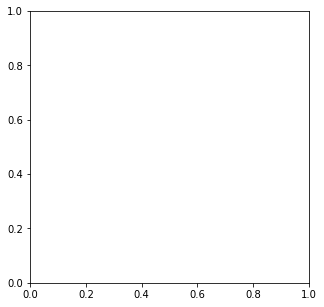

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies2, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .45, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, test_accuracies2, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .45, step=0.05))
plt.title("Test Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Test Accuracy")
plt.show()

In [ ]:
while True:pass

# Encryption

In [ ]:
#RANDOM 
epsilons = [0.5]  #[0.2, 0.3, 0.4, 0.5, 0.6, 0.7]   #[0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.01, 0.008, 0.005, 0.002 ]  
accuracies2 = []
examples2 = []
test_accuracies2 = []
test_examples2 = []
original_examples2 = []
attacked_examples2 = []

# Run train for each epsilon
acc, ex = training(25 , model, device, train_loader)
accuracies2.append(acc)
examples2.append(ex)
for eps in epsilons:
    print("##### TESTING ON ResNET",eps,"########")
    test_acc, test_ex ,ori_ex ,attack_ex= testing_res(model, device, test_loader, eps)
    test_accuracies2.append(test_acc)
    test_examples2.append(test_ex)
    original_examples2.append(ori_ex)
    attacked_examples2.append(attack_ex)
    print("##### TESTING ON VGG",eps,"########")
    test_acc, test_ex ,ori_ex ,attack_ex= testing_vgg(vgg, device, test_loader, eps)
    print("######################################################")

In [ ]:
acc, ex = training(20 , model, device, train_loader)
accuracies2.append(acc)
examples2.append(ex)
for eps in epsilons:
    print("##### TESTING ON ResNET",eps,"########")
    test_acc, test_ex ,ori_ex ,attack_ex= testing_res(model, device, test_loader, eps)
    test_accuracies2.append(test_acc)
    test_examples2.append(test_ex)
    original_examples2.append(ori_ex)
    attacked_examples2.append(attack_ex)
    print("##### TESTING ON VGG",eps,"########")
    test_acc, test_ex ,ori_ex ,attack_ex= testing_vgg(vgg, device, test_loader, eps)
    print("######################################################")

In [ ]:
model.eval()
def training_new(epochs, model, device, test_loader, epsilon):

    losses_g = []
    losses_d = []
    losses_g2 = []
    losses_md = []
    # Accuracy counter
    correct = 0
    adv_examples = []
    start_idx = 0
    # Loop over all examples in test set
    for epoch in range(epochs):
      generator.train()
      discriminator.train()
      correct = 0
      d_running_loss = 0.0
      g_running_loss = 0.0
      md_running_loss = 0.0
      g_running_loss2 = 0.0

      for batch in tqdm(test_loader):
        data, target = batch
        start_idx = start_idx+1
        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True 

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        # if init_pred.item() != target.item():
        #     continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        #Training GANs
        gen_image , d_loss , g_loss  , g_loss2 = train(perturbed_data , data , target)
        
        d_running_loss += d_loss
        g_running_loss += g_loss
        
        g_running_loss2 += g_loss2
        
        # Re-classify the perturbed image
        output = model(gen_image)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        final_pred.squeeze(1)
        for indx in range(len(final_pred)):
            if final_pred[indx].item() == target[indx].item():
                correct += 1
                # Special case for saving 0 epsilon examples
                if (epsilon == 0) and (len(adv_examples) < 5):
                    adv_ex = gen_image[indx].squeeze().detach().cpu().numpy()
                    adv_examples.append( (init_pred[indx].item(), final_pred[indx].item(), adv_ex) )
            else:
                # Save some adv examples for visualization later
                if len(adv_examples) < 5:
                    adv_ex = gen_image[indx].squeeze().detach().cpu().numpy()
                    adv_examples.append( (init_pred[indx].item(), final_pred[indx].item(), adv_ex) )

    # Calculate final accuracy for this epsilon
      print('Epoch : {} , g_epoch_loss : {:.4f} , d_epoch_loss : {:.4f} , g_epoch_loss2 : {:.4f} , md_epoch_loss : {:.4f}'.format(epoch,g_running_loss/float(len(test_loader)),d_running_loss/float(len(test_loader)),g_running_loss/float(len(test_loader)),d_running_loss/float(len(test_loader))))

      final_acc = correct/float(sum([len(itm[1]) for itm in train_loader]))
      print("Epsilon: {}\tTraining Accuracy = {} / {} = {}".format(epsilon, correct, sum([len(itm[1]) for itm in train_loader]), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [ ]:
torch.save(discriminator.state_dict(), "Crypto_Random_Disc.pth")
torch.save(generator.state_dict(), "Crypto_Random_Gen.pth")

In [ ]:
def save_arr(arr, name):
    with open(name, 'wb') as f:
        pickle.dump(arr, f)

In [ ]:
#SAVE RANDOM

save_arr(accuracies2, "Crypto_Random_acc")
save_arr(examples2, "Crypto_Random_examples")
save_arr(test_accuracies2, "Crypto_Random_test_accuracies")
save_arr(test_examples2, "Crypto_Random_test_examples")
save_arr(original_examples2, "Crypto_Random_original_examples")
save_arr(attacked_examples2, "Crypto_Random_attacked_examples")

# Increasing

In [ ]:
discriminator = DNet()
generator = UNet(True)
generator.cuda()
discriminator.cuda()
g_optimizer = torch.optim.Adam(generator.parameters() , betas=(0.5,0.999) , lr = 0.0002)
d_optimizer = torch.optim.Adam(
    discriminator.parameters(), 
    betas=(0.5,0.999), 
    lr = 0.0002
)

In [ ]:
#Increasing
epsilons = [0.5]   #[0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.01, 0.008, 0.005, 0.002 ]  
accuracies = []
examples = []
test_accuracies = []
test_examples = []
original_examples = []
attacked_examples = []

# Run train for each epsilon
for eps in epsilons:
    acc, ex = training_new(100 , model, device, train_loader, eps)
    accuracies.append(acc)
    examples.append(ex)
    print("##### TESTING ON ResNET",eps,"########")
    test_acc, test_ex ,ori_ex ,attack_ex= testing_res(model, device, test_loader, eps)
    test_accuracies.append(test_acc)
    test_examples.append(test_ex)
    original_examples.append(ori_ex)
    attacked_examples.append(attack_ex)
    print("##### TESTING ON VGG",eps,"########")
    test_acc, test_ex ,ori_ex ,attack_ex= testing_vgg(vgg, device, test_loader, eps)
    print("######################################################")


Epoch : 0 , g_epoch_loss : 2.7761 , d_epoch_loss : 0.9256 , g_epoch_loss2 : 2.7761 , md_epoch_loss : 0.9256
Epsilon: 0.5	Training Accuracy = 6721 / 50000 = 0.13442



Epoch : 1 , g_epoch_loss : 2.9850 , d_epoch_loss : 0.8983 , g_epoch_loss2 : 2.9850 , md_epoch_loss : 0.8983
Epsilon: 0.5	Training Accuracy = 6883 / 50000 = 0.13766



Epoch : 2 , g_epoch_loss : 2.5224 , d_epoch_loss : 0.9769 , g_epoch_loss2 : 2.5224 , md_epoch_loss : 0.9769
Epsilon: 0.5	Training Accuracy = 7408 / 50000 = 0.14816


In [ ]:
while True:pass

In [ ]:
#Increasing
epsilons = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]   #[0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.01, 0.008, 0.005, 0.002 ]  
accuracies = []
examples = []
test_accuracies = []
test_examples = []
original_examples = []
attacked_examples = []

# Run train for each epsilon
for eps in epsilons:
    acc, ex = training_new(10 , model, device, train_loader, eps)
    accuracies.append(acc)
    examples.append(ex)
    print("##### TESTING ON ResNET",eps,"########")
    test_acc, test_ex ,ori_ex ,attack_ex= testing_res(model, device, test_loader, eps)
    test_accuracies.append(test_acc)
    test_examples.append(test_ex)
    original_examples.append(ori_ex)
    attacked_examples.append(attack_ex)
    print("##### TESTING ON VGG",eps,"########")
    test_acc, test_ex ,ori_ex ,attack_ex= testing_vgg(vgg, device, test_loader, eps)
    print("######################################################")

In [ ]:
torch.save(discriminator.state_dict(), "Crypto_Increasing_Disc.pth")
torch.save(generator.state_dict(), "Crypto_Increasing_Gen.pth")

In [ ]:
#SAVE Increasing

save_arr(accuracies, "Crypto_Increasing_acc")
save_arr(examples, "Crypto_Increasing_examples")
save_arr(test_accuracies, "Crypto_Increasing_test_accuracies")
save_arr(test_examples, "Crypto_Increasing_test_examples")
save_arr(original_examples, "Crypto_Increasing_original_examples")
save_arr(attacked_examples, "Crypto_Increasing_attacked_examples")

In [ ]:
discriminator = DNet()
generator = UNet(True)
generator.cuda()
discriminator.cuda()
g_optimizer = torch.optim.Adam(generator.parameters() , betas=(0.5,0.999) , lr = 0.0002)
d_optimizer = torch.optim.Adam(
    discriminator.parameters(), 
    betas=(0.5,0.999), 
    lr = 0.0002
)

In [ ]:
#Decreasing
epsilons = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]   #[0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.01, 0.008, 0.005, 0.002 ]  
accuracies1 = []
examples1 = []
test_accuracies1 = []
test_examples1 = []
original_examples1 = []
attacked_examples1 = []

# Run train for each epsilon
for eps in epsilons[::-1]:
    acc, ex = training_new(10 , model, device, train_loader, eps)
    accuracies1.append(acc)
    examples1.append(ex)
    print("##### TESTING ON ResNET",eps,"########")
    test_acc, test_ex ,ori_ex ,attack_ex= testing_res(model, device, test_loader, eps)
    test_accuracies1.append(test_acc)
    test_examples1.append(test_ex)
    original_examples1.append(ori_ex)
    attacked_examples1.append(attack_ex)
    print("##### TESTING ON VGG",eps,"########")
    test_acc, test_ex ,ori_ex ,attack_ex= testing_vgg(vgg, device, test_loader, eps)
    print("######################################################")


Epoch : 0 , g_epoch_loss : 1.4113 , d_epoch_loss : 1.1306 , g_epoch_loss2 : 1.4113 , md_epoch_loss : 1.1306
Epsilon: 0.7	Training Accuracy = 35597 / 50000 = 0.71194



Epoch : 1 , g_epoch_loss : 1.4857 , d_epoch_loss : 1.1006 , g_epoch_loss2 : 1.4857 , md_epoch_loss : 1.1006
Epsilon: 0.7	Training Accuracy = 35867 / 50000 = 0.71734



Epoch : 2 , g_epoch_loss : 1.5004 , d_epoch_loss : 1.0867 , g_epoch_loss2 : 1.5004 , md_epoch_loss : 1.0867
Epsilon: 0.7	Training Accuracy = 36438 / 50000 = 0.72876



Epoch : 3 , g_epoch_loss : 1.4729 , d_epoch_loss : 1.0948 , g_epoch_loss2 : 1.4729 , md_epoch_loss : 1.0948
Epsilon: 0.7	Training Accuracy = 37200 / 50000 = 0.744



Epoch : 4 , g_epoch_loss : 1.5789 , d_epoch_loss : 1.0641 , g_epoch_loss2 : 1.5789 , md_epoch_loss : 1.0641
Epsilon: 0.7	Training Accuracy = 36710 / 50000 = 0.7342



Epoch : 5 , g_epoch_loss : 1.4390 , d_epoch_loss : 1.1222 , g_epoch_loss2 : 1.4390 , md_epoch_loss : 1.1222
Epsilon: 0.7	Training Accuracy = 37364 / 50000 = 0.74728



Epoch : 6 , g_epoch_loss : 1.4140 , d_epoch_loss : 1.1191 , g_epoch_loss2 : 1.4140 , md_epoch_loss : 1.1191
Epsilon: 0.7	Training Accuracy = 38232 / 50000 = 0.76464



Epoch : 7 , g_epoch_loss : 1.3867 , d_epoch_loss : 1.1415 , g_epoch_loss2 : 1.3867 , md_epoch_loss : 1.1415
Epsilon: 0.7	Training Accuracy = 38747 / 50000 = 0.77494



Epoch : 8 , g_epoch_loss : 1.3846 , d_epoch_loss : 1.1333 , g_epoch_loss2 : 1.3846 , md_epoch_loss : 1.1333
Epsilon: 0.7	Training Accuracy = 39350 / 50000 = 0.787



Epoch : 9 , g_epoch_loss : 1.3823 , d_epoch_loss : 1.1370 , g_epoch_loss2 : 1.3823 , md_epoch_loss : 1.1370
Epsilon: 0.7	Training Accuracy = 39549 / 50000 = 0.79098
##### TESTING ON ResNET 0.7 ########



Epsilon: 0.7	Test Accuracy by Resnet-18 = 6525 / 10000 = 0.6525
##### TESTING ON VGG 0.7 ########


RuntimeError: ignored

In [ ]:
while True:pass

In [ ]:
#Decreasing
epsilons =  [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]  #[0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.01, 0.008, 0.005, 0.002 ]  
accuracies1 = []
examples1 = []
test_accuracies1 = []
test_examples1 = []
original_examples1 = []
attacked_examples1 = []

# Run train for each epsilon
for eps in epsilons[::-1]:
    acc, ex = training_new(10 , model, device, train_loader, eps)
    accuracies1.append(acc)
    examples1.append(ex)
    print("##### TESTING ON ResNET",eps,"########")
    test_acc, test_ex ,ori_ex ,attack_ex= testing_res(model, device, test_loader, eps)
    test_accuracies1.append(test_acc)
    test_examples1.append(test_ex)
    original_examples1.append(ori_ex)
    attacked_examples1.append(attack_ex)
    print("##### TESTING ON VGG",eps,"########")
    test_acc, test_ex ,ori_ex ,attack_ex= testing_vgg(vgg, device, test_loader, eps)
    print("######################################################")

In [ ]:
#SAVE Decreasing
torch.save(discriminator.state_dict(), "Crypto_Decreasing_Disc.pth")
torch.save(generator.state_dict(), "Crypto_Decreasing_Gen.pth")
save_arr(accuracies1, "Crypto_Decreasing_acc")
save_arr(examples1, "Crypto_Decreasing_examples")
save_arr(test_accuracies1, "Crypto_Decreasing_test_accuracies")
save_arr(test_examples1, "Crypto_Decreasing_test_examples")
save_arr(original_examples1, "Crypto_Decreasing_original_examples")
save_arr(attacked_examples1, "Crypto_Decreasing_attacked_examples")

In [ ]:
#Test All
for eps in epsilons:
    print("##### TESTING ON ResNET",eps,"########")
    test_acc, test_ex ,ori_ex ,attack_ex= testing_res(model, device, test_loader, eps)
    test_accuracies2.append(test_acc)
    test_examples2.append(test_ex)
    original_examples2.append(ori_ex)
    attacked_examples2.append(attack_ex)
    print("##### TESTING ON VGG",eps,"########")
    test_acc, test_ex ,ori_ex ,attack_ex= testing_vgg(vgg, device, test_loader, eps)
    print("######################################################")

##### TESTING ON ResNET 0.2 ########



Epsilon: 0.2	Test Accuracy by Resnet-18 = 9380 / 10000 = 0.938
##### TESTING ON VGG 0.2 ########



Epsilon: 0.2	Test Accuracy by vgg-13 = 9325 / 10000 = 0.9325
######################################################
##### TESTING ON ResNET 0.3 ########



Epsilon: 0.3	Test Accuracy by Resnet-18 = 989 / 10000 = 0.0989
##### TESTING ON VGG 0.3 ########



Epsilon: 0.3	Test Accuracy by vgg-13 = 2132 / 10000 = 0.2132
######################################################
##### TESTING ON ResNET 0.4 ########



Epsilon: 0.4	Test Accuracy by Resnet-18 = 936 / 10000 = 0.0936
##### TESTING ON VGG 0.4 ########



Epsilon: 0.4	Test Accuracy by vgg-13 = 1219 / 10000 = 0.1219
######################################################
##### TESTING ON ResNET 0.5 ########



Epsilon: 0.5	Test Accuracy by Resnet-18 = 955 / 10000 = 0.0955
##### TESTING ON VGG 0.5 ########



Epsilon: 0.5	Test Accuracy by vgg-13 = 1061 / 10000 = 0.1061
######################################################
##### TESTING ON ResNET 0.6 ########



Epsilon: 0.6	Test Accuracy by Resnet-18 = 986 / 10000 = 0.0986
##### TESTING ON VGG 0.6 ########


KeyboardInterrupt: 

In [ ]:
for eps in epsilons:
    print("##### TESTING ON ResNET",eps,"########")
    test_acc, test_ex ,ori_ex ,attack_ex= testing_res(model, device, test_loader, eps)
    test_accuracies2.append(test_acc)
    test_examples2.append(test_ex)
    original_examples2.append(ori_ex)
    attacked_examples2.append(attack_ex)
    print("##### TESTING ON VGG",eps,"########")
    test_acc, test_ex ,ori_ex ,attack_ex= testing_vgg(vgg, device, test_loader, eps)
    print("######################################################")

##### TESTING ON ResNET 0 ########



Epsilon: 0	Test Accuracy by Resnet-18 = 9063 / 10000 = 0.9063
##### TESTING ON VGG 0 ########



Epsilon: 0	Test Accuracy by vgg-13 = 9280 / 10000 = 0.928
######################################################
##### TESTING ON ResNET 0.002 ########



Epsilon: 0.002	Test Accuracy by Resnet-18 = 7722 / 10000 = 0.7722
##### TESTING ON VGG 0.002 ########



Epsilon: 0.002	Test Accuracy by vgg-13 = 8100 / 10000 = 0.81
######################################################
##### TESTING ON ResNET 0.005 ########



Epsilon: 0.005	Test Accuracy by Resnet-18 = 5381 / 10000 = 0.5381
##### TESTING ON VGG 0.005 ########



Epsilon: 0.005	Test Accuracy by vgg-13 = 6355 / 10000 = 0.6355
######################################################
##### TESTING ON ResNET 0.008 ########



Epsilon: 0.008	Test Accuracy by Resnet-18 = 3644 / 10000 = 0.3644
##### TESTING ON VGG 0.008 ########



Epsilon: 0.008	Test Accuracy by vgg-13 = 5496 / 10000 = 0.5496
######################################################
##### TESTING ON ResNET 0.01 ########



Epsilon: 0.01	Test Accuracy by Resnet-18 = 2849 / 10000 = 0.2849
##### TESTING ON VGG 0.01 ########



Epsilon: 0.01	Test Accuracy by vgg-13 = 5169 / 10000 = 0.5169
######################################################
##### TESTING ON ResNET 0.015 ########



Epsilon: 0.015	Test Accuracy by Resnet-18 = 1730 / 10000 = 0.173
##### TESTING ON VGG 0.015 ########



Epsilon: 0.015	Test Accuracy by vgg-13 = 4721 / 10000 = 0.4721
######################################################
##### TESTING ON ResNET 0.02 ########



Epsilon: 0.02	Test Accuracy by Resnet-18 = 1228 / 10000 = 0.1228
##### TESTING ON VGG 0.02 ########



Epsilon: 0.02	Test Accuracy by vgg-13 = 4471 / 10000 = 0.4471
######################################################


In [ ]:
import pickle
#attacked_examples, original_examples, test_examples
with open('attacked_examples_Increasing.pkl', 'wb') as f:
    pickle.dump(attacked_examples, f)
with open('original_examples_Increasing.pkl', 'wb') as f:
    pickle.dump(original_examples, f)
with open('test_examples_Increasing.pkl', 'wb') as f:
    pickle.dump(test_examples, f)
    

In [ ]:
# torch.save(generator.state_dict() , "generator_new_batch_reverse.pth")
# torch.save(discriminator.state_dict(), "discriminator_new_batch_reverse.pth")
# discriminator = DNet()
# generator = UNet(True)
# generator.cuda()
# discriminator.cuda()

"""
Forward :
Epsilon: 0.002	Test Accuracy = 8084 / 10000 = 0.8084
Epsilon: 0.005	Test Accuracy = 7791 / 10000 = 0.7791
Epsilon: 0.008	Test Accuracy = 7830 / 10000 = 0.783
Epsilon: 0.01	Test Accuracy = 7800 / 10000 = 0.78
Epsilon: 0.05	Test Accuracy = 8648 / 10000 = 0.8648
Epsilon: 0.1	Test Accuracy = 8767 / 10000 = 0.8767
Epsilon: 0.15	Test Accuracy = 9257 / 10000 = 0.9257
Epsilon: 0.2	Test Accuracy = 9192 / 10000 = 0.9192
Epsilon: 0.25	Test Accuracy = 9163 / 10000 = 0.9163
Epsilon: 0.3	Test Accuracy = 9341 / 10000 = 0.9341
Backward :
Epsilon: 0.3	Test Accuracy = 9597 / 10000 = 0.9597
Epsilon: 0.25	Test Accuracy = 9604 / 10000 = 0.9604
Epsilon: 0.2	Test Accuracy = 9671 / 10000 = 0.9671
Epsilon: 0.15	Test Accuracy = 9285 / 10000 = 0.9285
Epsilon: 0.1	Test Accuracy = 9227 / 10000 = 0.9227
Epsilon: 0.05	Test Accuracy = 8564 / 10000 = 0.8564
Epsilon: 0.01	Test Accuracy = 8035 / 10000 = 0.8035
Epsilon: 0.008	Test Accuracy = 8059 / 10000 = 0.8059
Epsilon: 0.005	Test Accuracy = 7964 / 10000 = 0.7964
Epsilon: 0.002	Test Accuracy = 8212 / 10000 = 0.8212
"""

In [ ]:
torch.save(generator.state_dict() , "generator_random.pth")
torch.save(discriminator.state_dict(), "discriminator_random.pth")
discriminator = DNet()
generator = UNet(True)
generator.cuda()
discriminator.cuda()

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .45, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, test_accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .45, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()



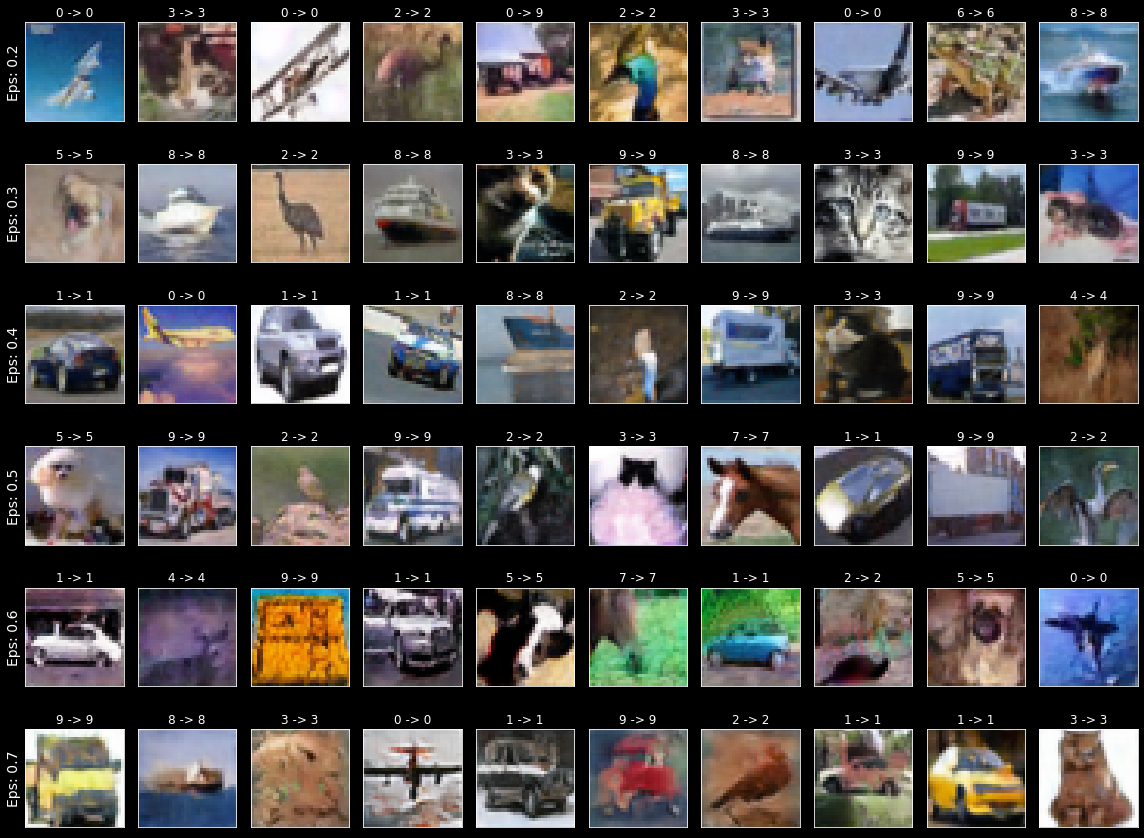

In [ ]:
# Plot several examples of adversarial samples at each epsilon
#GENERATED BY GAN
plt.style.use("dark_background")
cnt = 0
plt.figure(figsize=(16,12))
for i in range(len(epsilons)):
    for j in range(len(test_examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(test_examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = test_examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex.transpose(1,2,0))
plt.tight_layout()
plt.show()

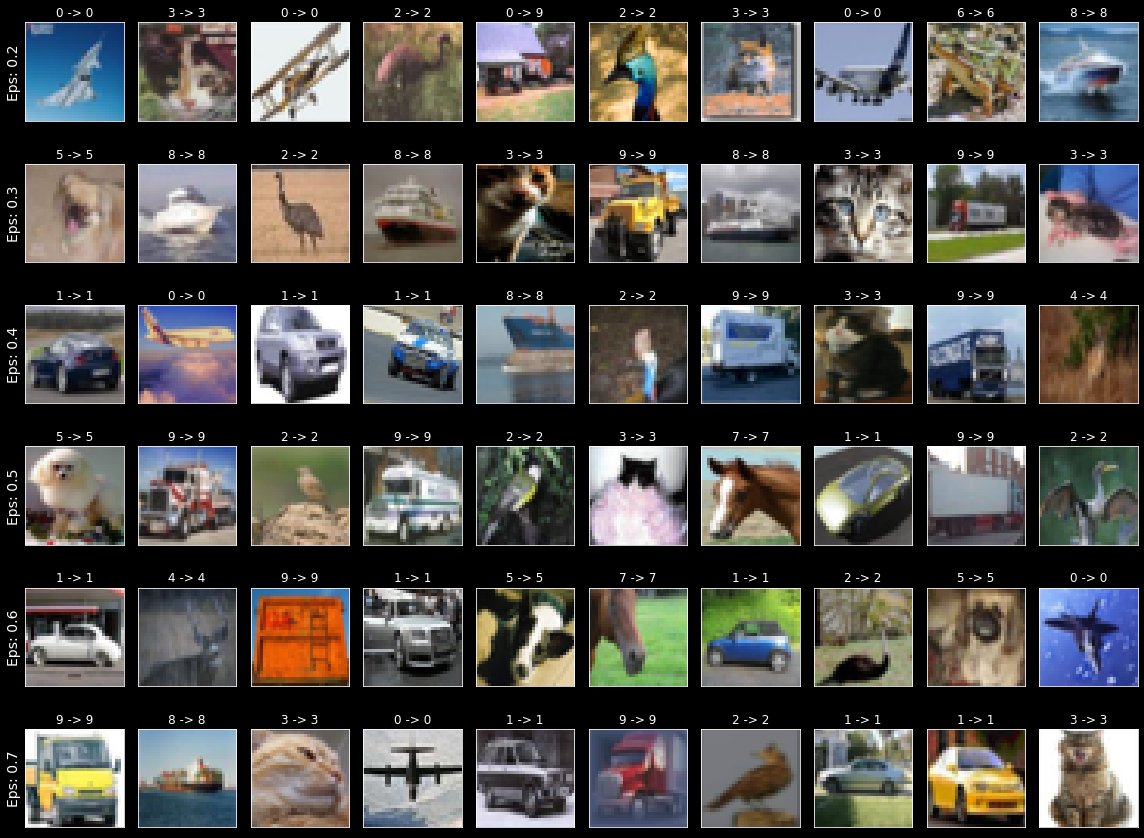

In [ ]:
# Plot several examples of adversarial samples at each epsilon
#Original
cnt = 0
plt.figure(figsize=(16,12))
for i in range(len(epsilons)):
    for j in range(len(original_examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(original_examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = original_examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex.transpose(1,2,0))
plt.tight_layout()
plt.show()

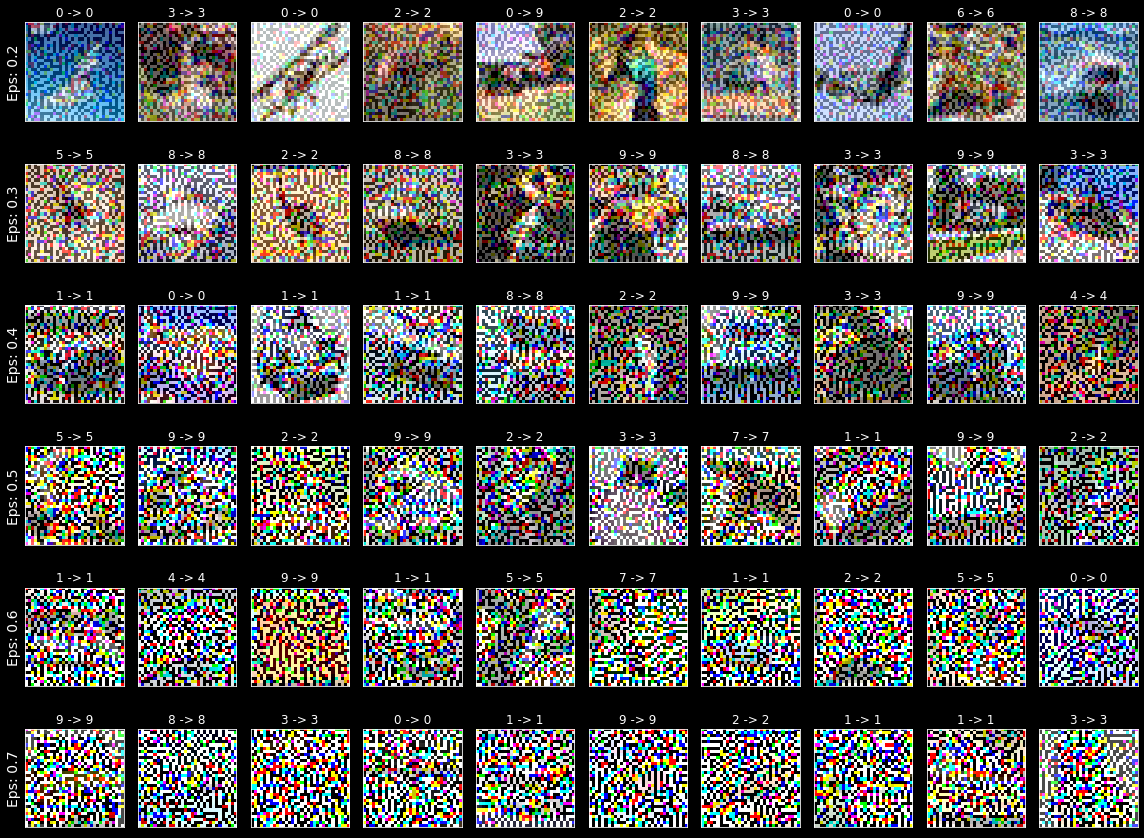

In [ ]:
# Plot several examples of adversarial samples at each epsilon
#ATTACKED
cnt = 0
plt.figure(figsize=(16,12))
for i in range(len(epsilons)):
    for j in range(len(attacked_examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(attacked_examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = attacked_examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex.transpose(1,2,0))
plt.tight_layout()
plt.show()

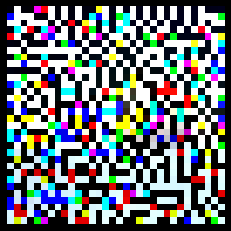

In [ ]:
plt.axis('off')
plt.imshow(attacked_examples[-1][1][2].transpose(1,2,0))
plt.savefig('a.jpg', dpi=1000)